In [2]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import pandas

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path


mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [3]:
from torch.utils.data import Dataset, DataLoader, Sampler
# without transformation at the batch step


In [4]:
from torch.utils.data import Dataset, DataLoader, Sampler
class SimpleDataset(Dataset):
    def __init__(self, x, y, e, transform=False, covlist = None, mean=0, std = 1):
        self.data = x
        self.targets = y
        self.label = e
        self.transform = transform
        self.covlist = covlist
        if not self.covlist:
            self.covlist = np.arange(self.data.shape[1])
        
        if self.transform:
            self.mean, self.std = mean, std
            
    def __getitem__(self, index):
        img = self.data[index]
        target = self.targets[index]
        label = self.label[index]
        
        if self.transform:
            return (img[self.covlist]-self.mean)/self.std, target, label
        else:
            return img, target, label
        
        

    def __len__(self):
        return len(self.data)
  

## Cox-gompertz linear setting

Load framingham dataset

In [5]:
from data.simulation import simulation_cox_weibull_all

file_path = '/data/zidi/framingham/'
result_path_root = '/data/zidi/ACSurv/results/toy'
# file_path = '/Users/ZidiXiu/Dropbox/Research/framingham/data/'
# result_path_root = "/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results"+'/toy'

cut_bound = 6
df= simulation_cox_weibull_all(n=20000, censor_bound=0)

# change to non-ohe 

nsamples, ncov= df['x'].shape
cat0 = np.arange(df['ohe'][0])
cat1 = np.arange(df['ohe'][1])
cov_list = np.array(['AGE','RANDON']+['cat0_'+str(a) for a in cat0]+['cat1_'+str(a) for a in cat1])
cts_idx = df['cts_idx']
cts_var = cov_list[cts_idx]
cat_idx = np.setdiff1d(np.arange(ncov), cts_idx)
cat_var = cov_list[cat_idx]

np.mean(df['e'])

1.0

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

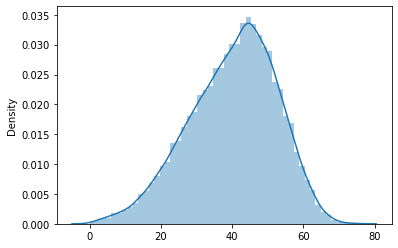

In [6]:
sns.distplot(df['T'])

In [7]:
from data.utils import *
nsamples, ncov= df['x'].shape
np.random.seed(123)
all_idx = np.arange(nsamples)
all_idx = np.random.permutation(all_idx)
train_idx = all_idx[:int(2*nsamples/3)]
valid_idx = all_idx[int(2*nsamples/3):]

train = formatted_data(df['x'], df['t'], df['e'], train_idx)
valid = formatted_data(df['x'], df['t'], df['e'], valid_idx)

del df

observed fold:1.0
observed fold:1.0


In [8]:
ncov, cov_list

(106,
 array(['AGE', 'RANDON', 'cat0_0', 'cat0_1', 'cat0_2', 'cat0_3', 'cat1_0',
        'cat1_1', 'cat1_2', 'cat1_3', 'cat1_4', 'cat1_5', 'cat1_6',
        'cat1_7', 'cat1_8', 'cat1_9', 'cat1_10', 'cat1_11', 'cat1_12',
        'cat1_13', 'cat1_14', 'cat1_15', 'cat1_16', 'cat1_17', 'cat1_18',
        'cat1_19', 'cat1_20', 'cat1_21', 'cat1_22', 'cat1_23', 'cat1_24',
        'cat1_25', 'cat1_26', 'cat1_27', 'cat1_28', 'cat1_29', 'cat1_30',
        'cat1_31', 'cat1_32', 'cat1_33', 'cat1_34', 'cat1_35', 'cat1_36',
        'cat1_37', 'cat1_38', 'cat1_39', 'cat1_40', 'cat1_41', 'cat1_42',
        'cat1_43', 'cat1_44', 'cat1_45', 'cat1_46', 'cat1_47', 'cat1_48',
        'cat1_49', 'cat1_50', 'cat1_51', 'cat1_52', 'cat1_53', 'cat1_54',
        'cat1_55', 'cat1_56', 'cat1_57', 'cat1_58', 'cat1_59', 'cat1_60',
        'cat1_61', 'cat1_62', 'cat1_63', 'cat1_64', 'cat1_65', 'cat1_66',
        'cat1_67', 'cat1_68', 'cat1_69', 'cat1_70', 'cat1_71', 'cat1_72',
        'cat1_73', 'cat1_74', 'cat1_75',

In [9]:
from sklearn import linear_model

model_name = 'lasso'

alpha_list = [1e-6, 5e-5, 1e-5, 1e-4,1e-3,1e-2,1e-1]
for alpha_ in alpha_list:
    lasso = linear_model.Lasso(alpha=alpha_)

    input_size = train['x'].shape[1]

    lasso.fit(train['x'], train['t'])
    lasso_pred_t = lasso.predict(valid['x'])
    valid_loss = ((valid['t']-lasso_pred_t)**2).sum()
    
#     plt.plot(lasso_pred_t, valid['t'])
    print(valid_loss)



/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354.89027792349225, tolerance: 199.68291224140128
  model = cd_fast.enet_coordinate_descent(


237975.13488148613
237959.24959802412


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357.6457662792527, tolerance: 199.68291224140128
  model = cd_fast.enet_coordinate_descent(


237972.26062387534
237943.313038569
237702.85507646675
239641.05201174924
247761.41290554256


237702.85507646675


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'True Event')

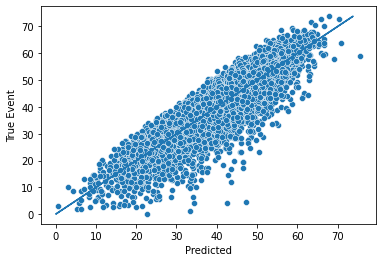

In [11]:
lasso = linear_model.Lasso(alpha=alpha_list[4])

input_size = train['x'].shape[1]

lasso.fit(train['x'], train['t'])
lasso_pred_t = lasso.predict(valid['x'])
valid_loss = ((valid['t']-lasso_pred_t)**2).sum()

print(valid_loss)
subj = np.random.choice(len(valid['e']))
plt.figure()

sns.scatterplot(lasso_pred_t[valid['e']==1], valid['t'][valid['e']==1])
plt.plot(valid['t'][valid['e']==1], valid['t'][valid['e']==1])
plt.xlabel('Predicted')
plt.ylabel('True Event')

In [12]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

class EncMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(EncMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        z = self.net(x)
        return z
    
class DecMLP_cts(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP_cts, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
#         self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        return z

    
class DecMLP_clf(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(DecMLP_clf, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)
    
    
class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(SimpleMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)

In [13]:
ncov = train['x'].shape[1]
covList = np.arange(ncov)
mean = np.mean(train['x'], axis=0)
std = np.std(train['x'], axis=0)

trainData = SimpleDataset(train['x'], train['t'], train['e'], transform=True, mean=mean, std = std)
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(valid['x'], valid['t'], valid['e'], transform=True, mean=mean, std = std)
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

In [14]:
result_path_root

'/data/zidi/ACSurv/results/toy'

In [15]:
zdim = 10
epochs = 1000
device = 'cuda'
model_name = 'MLP'
result_path = result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])
decoder = DecMLP_cts(input_size = zdim, output_size = 1, h_dim=[128,128])

encoder.to(device)
decoder.to(device)

# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-5)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-5)
enc_path = result_path+model_name+'_enc.pt'
dec_path = result_path+model_name+'_dec.pt'

print(encoder, decoder)

EncMLP(
  (net): Sequential(
    (0): Linear(in_features=106, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
) DecMLP_cts(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


epoch1
====> Train NLL: 866392.9492 	 Valid event loss: 1695016.4185 	 censoring loss : 0.0000 	 Improved: *
epoch2
====> Train NLL: 865921.7873 	 Valid event loss: 1694092.6904 	 censoring loss : 0.0000 	 Improved: *
epoch3
====> Train NLL: 865441.4859 	 Valid event loss: 1693146.4324 	 censoring loss : 0.0000 	 Improved: *
epoch4
====> Train NLL: 864944.4717 	 Valid event loss: 1692154.0459 	 censoring loss : 0.0000 	 Improved: *
epoch5
====> Train NLL: 864420.4055 	 Valid event loss: 1691102.0246 	 censoring loss : 0.0000 	 Improved: *
epoch6
====> Train NLL: 863864.8299 	 Valid event loss: 1689994.0837 	 censoring loss : 0.0000 	 Improved: *
epoch7
====> Train NLL: 863281.5829 	 Valid event loss: 1688830.9308 	 censoring loss : 0.0000 	 Improved: *
epoch8
====> Train NLL: 862668.0718 	 Valid event loss: 1687603.4494 	 censoring loss : 0.0000 	 Improved: *
epoch9
====> Train NLL: 862019.6939 	 Valid event loss: 1686309.8607 	 censoring loss : 0.0000 	 Improved: *
epoch10


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


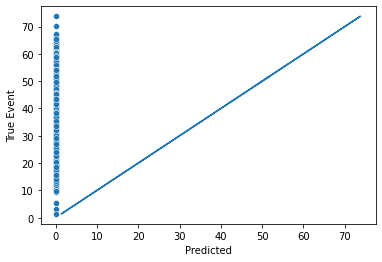

====> Train NLL: 861340.4085 	 Valid event loss: 1684955.2800 	 censoring loss : 0.0000 	 Improved: *
epoch11
====> Train NLL: 860629.3315 	 Valid event loss: 1683538.7898 	 censoring loss : 0.0000 	 Improved: *
epoch12
====> Train NLL: 859885.2170 	 Valid event loss: 1682058.4974 	 censoring loss : 0.0000 	 Improved: *
epoch13
====> Train NLL: 859105.9926 	 Valid event loss: 1680505.2526 	 censoring loss : 0.0000 	 Improved: *
epoch14
====> Train NLL: 858288.4957 	 Valid event loss: 1678863.3450 	 censoring loss : 0.0000 	 Improved: *
epoch15
====> Train NLL: 857419.8044 	 Valid event loss: 1677116.6820 	 censoring loss : 0.0000 	 Improved: *
epoch16
====> Train NLL: 856491.1702 	 Valid event loss: 1675248.4021 	 censoring loss : 0.0000 	 Improved: *
epoch17
====> Train NLL: 855500.3476 	 Valid event loss: 1673243.9488 	 censoring loss : 0.0000 	 Improved: *
epoch18
====> Train NLL: 854435.5368 	 Valid event loss: 1671089.9178 	 censoring loss : 0.0000 	 Improved: *
epoch19
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


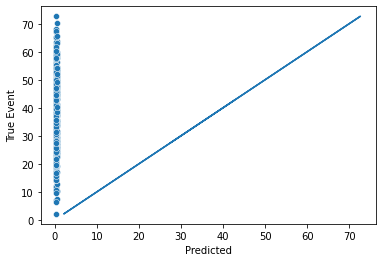

====> Train NLL: 852055.7754 	 Valid event loss: 1666268.0436 	 censoring loss : 0.0000 	 Improved: *
epoch21
====> Train NLL: 850725.8546 	 Valid event loss: 1663585.2585 	 censoring loss : 0.0000 	 Improved: *
epoch22
====> Train NLL: 849299.2099 	 Valid event loss: 1660697.7643 	 censoring loss : 0.0000 	 Improved: *
epoch23
====> Train NLL: 847757.8554 	 Valid event loss: 1657548.7066 	 censoring loss : 0.0000 	 Improved: *
epoch24
====> Train NLL: 846056.1472 	 Valid event loss: 1654045.6222 	 censoring loss : 0.0000 	 Improved: *
epoch25
====> Train NLL: 844170.6927 	 Valid event loss: 1650188.8006 	 censoring loss : 0.0000 	 Improved: *
epoch26
====> Train NLL: 842118.3892 	 Valid event loss: 1646008.9721 	 censoring loss : 0.0000 	 Improved: *
epoch27
====> Train NLL: 839891.3817 	 Valid event loss: 1641490.7649 	 censoring loss : 0.0000 	 Improved: *
epoch28
====> Train NLL: 837490.5679 	 Valid event loss: 1636627.3218 	 censoring loss : 0.0000 	 Improved: *
epoch29
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


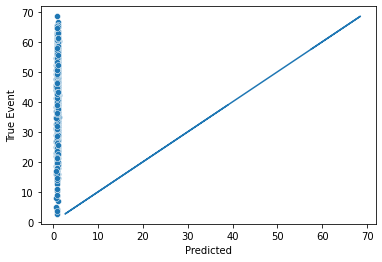

====> Train NLL: 832204.0859 	 Valid event loss: 1626016.8509 	 censoring loss : 0.0000 	 Improved: *
epoch31
====> Train NLL: 829335.1193 	 Valid event loss: 1620256.5479 	 censoring loss : 0.0000 	 Improved: *
epoch32
====> Train NLL: 826298.9277 	 Valid event loss: 1614160.2082 	 censoring loss : 0.0000 	 Improved: *
epoch33
====> Train NLL: 823075.9451 	 Valid event loss: 1607667.4133 	 censoring loss : 0.0000 	 Improved: *
epoch34
====> Train NLL: 819643.2756 	 Valid event loss: 1600715.9717 	 censoring loss : 0.0000 	 Improved: *
epoch35
====> Train NLL: 815977.7957 	 Valid event loss: 1593346.1296 	 censoring loss : 0.0000 	 Improved: *
epoch36
====> Train NLL: 812094.4545 	 Valid event loss: 1585594.8558 	 censoring loss : 0.0000 	 Improved: *
epoch37
====> Train NLL: 808028.0812 	 Valid event loss: 1577456.8160 	 censoring loss : 0.0000 	 Improved: *
epoch38
====> Train NLL: 803764.5622 	 Valid event loss: 1568909.7150 	 censoring loss : 0.0000 	 Improved: *
epoch39
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


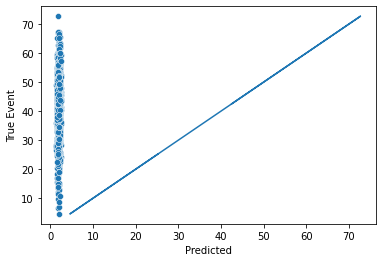

====> Train NLL: 794574.9105 	 Valid event loss: 1550530.6952 	 censoring loss : 0.0000 	 Improved: *
epoch41
====> Train NLL: 789642.6106 	 Valid event loss: 1540660.9028 	 censoring loss : 0.0000 	 Improved: *
epoch42
====> Train NLL: 784450.0290 	 Valid event loss: 1530313.7639 	 censoring loss : 0.0000 	 Improved: *
epoch43
====> Train NLL: 779024.3991 	 Valid event loss: 1519476.1628 	 censoring loss : 0.0000 	 Improved: *
epoch44
====> Train NLL: 773354.8536 	 Valid event loss: 1508142.8236 	 censoring loss : 0.0000 	 Improved: *
epoch45
====> Train NLL: 767426.1516 	 Valid event loss: 1496294.6664 	 censoring loss : 0.0000 	 Improved: *
epoch46
====> Train NLL: 761233.7618 	 Valid event loss: 1483922.5776 	 censoring loss : 0.0000 	 Improved: *
epoch47
====> Train NLL: 754747.0525 	 Valid event loss: 1471005.3552 	 censoring loss : 0.0000 	 Improved: *
epoch48
====> Train NLL: 747984.8010 	 Valid event loss: 1457538.8608 	 censoring loss : 0.0000 	 Improved: *
epoch49
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


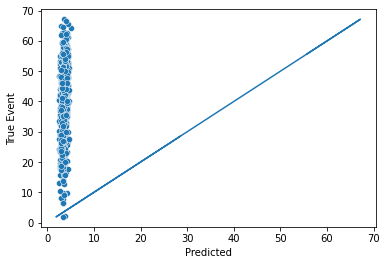

====> Train NLL: 733628.1135 	 Valid event loss: 1428919.6391 	 censoring loss : 0.0000 	 Improved: *
epoch51
====> Train NLL: 725995.3207 	 Valid event loss: 1413740.3346 	 censoring loss : 0.0000 	 Improved: *
epoch52
====> Train NLL: 718089.6748 	 Valid event loss: 1397960.0266 	 censoring loss : 0.0000 	 Improved: *
epoch53
====> Train NLL: 709839.6158 	 Valid event loss: 1381575.8672 	 censoring loss : 0.0000 	 Improved: *
epoch54
====> Train NLL: 701290.9912 	 Valid event loss: 1364576.0481 	 censoring loss : 0.0000 	 Improved: *
epoch55
====> Train NLL: 692427.4901 	 Valid event loss: 1346953.1508 	 censoring loss : 0.0000 	 Improved: *
epoch56
====> Train NLL: 683235.9277 	 Valid event loss: 1328702.6877 	 censoring loss : 0.0000 	 Improved: *
epoch57
====> Train NLL: 673652.5266 	 Valid event loss: 1309448.7211 	 censoring loss : 0.0000 	 Improved: *
epoch58
====> Train NLL: 663556.1158 	 Valid event loss: 1289350.8409 	 censoring loss : 0.0000 	 Improved: *
epoch59
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


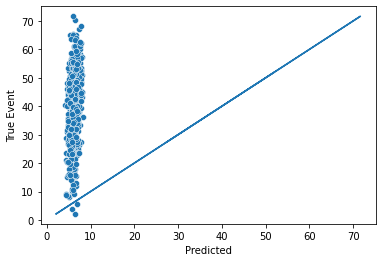

====> Train NLL: 642360.0837 	 Valid event loss: 1247396.9212 	 censoring loss : 0.0000 	 Improved: *
epoch61
====> Train NLL: 631292.6451 	 Valid event loss: 1225471.6950 	 censoring loss : 0.0000 	 Improved: *
epoch62
====> Train NLL: 619912.1842 	 Valid event loss: 1202887.3225 	 censoring loss : 0.0000 	 Improved: *
epoch63
====> Train NLL: 608149.6297 	 Valid event loss: 1179639.4559 	 censoring loss : 0.0000 	 Improved: *
epoch64
====> Train NLL: 596094.4375 	 Valid event loss: 1155716.1211 	 censoring loss : 0.0000 	 Improved: *
epoch65
====> Train NLL: 583680.5625 	 Valid event loss: 1131128.1583 	 censoring loss : 0.0000 	 Improved: *
epoch66
====> Train NLL: 570898.8233 	 Valid event loss: 1105869.0140 	 censoring loss : 0.0000 	 Improved: *
epoch67
====> Train NLL: 557795.5059 	 Valid event loss: 1079938.3450 	 censoring loss : 0.0000 	 Improved: *
epoch68
====> Train NLL: 544336.6549 	 Valid event loss: 1053335.7140 	 censoring loss : 0.0000 	 Improved: *
epoch69
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


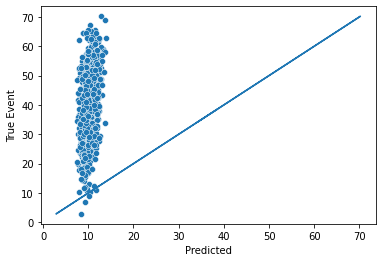

====> Train NLL: 516405.5776 	 Valid event loss: 998109.3868 	 censoring loss : 0.0000 	 Improved: *
epoch71
====> Train NLL: 501921.6742 	 Valid event loss: 969522.0099 	 censoring loss : 0.0000 	 Improved: *
epoch72
====> Train NLL: 487117.9294 	 Valid event loss: 940327.1983 	 censoring loss : 0.0000 	 Improved: *
epoch73
====> Train NLL: 472042.7033 	 Valid event loss: 910562.1396 	 censoring loss : 0.0000 	 Improved: *
epoch74
====> Train NLL: 456670.3368 	 Valid event loss: 880247.4942 	 censoring loss : 0.0000 	 Improved: *
epoch75
====> Train NLL: 441042.2810 	 Valid event loss: 849423.0346 	 censoring loss : 0.0000 	 Improved: *
epoch76
====> Train NLL: 425104.3398 	 Valid event loss: 818128.2654 	 censoring loss : 0.0000 	 Improved: *
epoch77
====> Train NLL: 408970.6041 	 Valid event loss: 786391.7993 	 censoring loss : 0.0000 	 Improved: *
epoch78
====> Train NLL: 392612.1639 	 Valid event loss: 754256.2477 	 censoring loss : 0.0000 	 Improved: *
epoch79
====> Train NLL: 37

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


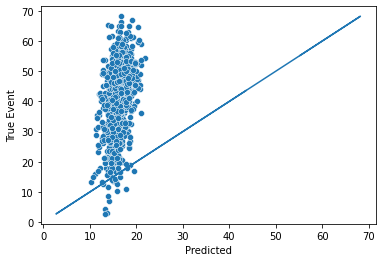

====> Train NLL: 359418.4254 	 Valid event loss: 689022.5900 	 censoring loss : 0.0000 	 Improved: *
epoch81
====> Train NLL: 342641.2575 	 Valid event loss: 656073.3926 	 censoring loss : 0.0000 	 Improved: *
epoch82
====> Train NLL: 325700.4704 	 Valid event loss: 623000.8096 	 censoring loss : 0.0000 	 Improved: *
epoch83
====> Train NLL: 308767.8983 	 Valid event loss: 589877.1217 	 censoring loss : 0.0000 	 Improved: *
epoch84
====> Train NLL: 291876.4890 	 Valid event loss: 556780.2267 	 censoring loss : 0.0000 	 Improved: *
epoch85
====> Train NLL: 274968.8926 	 Valid event loss: 523799.4552 	 censoring loss : 0.0000 	 Improved: *
epoch86
====> Train NLL: 258127.0808 	 Valid event loss: 491028.1545 	 censoring loss : 0.0000 	 Improved: *
epoch87
====> Train NLL: 241503.9732 	 Valid event loss: 458561.9790 	 censoring loss : 0.0000 	 Improved: *
epoch88
====> Train NLL: 225003.7553 	 Valid event loss: 426516.6253 	 censoring loss : 0.0000 	 Improved: *
epoch89
====> Train NLL: 20

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


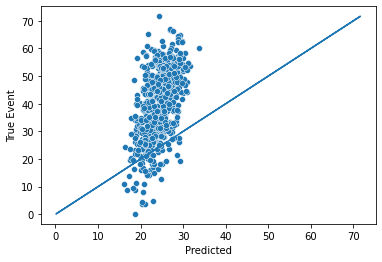

====> Train NLL: 192815.1843 	 Valid event loss: 364153.2447 	 censoring loss : 0.0000 	 Improved: *
epoch91
====> Train NLL: 177315.5290 	 Valid event loss: 334093.6120 	 censoring loss : 0.0000 	 Improved: *
epoch92
====> Train NLL: 162233.8969 	 Valid event loss: 304974.1013 	 censoring loss : 0.0000 	 Improved: *
epoch93
====> Train NLL: 147720.8765 	 Valid event loss: 276931.3948 	 censoring loss : 0.0000 	 Improved: *
epoch94
====> Train NLL: 133737.2392 	 Valid event loss: 250118.5469 	 censoring loss : 0.0000 	 Improved: *
epoch95
====> Train NLL: 120434.3987 	 Valid event loss: 224716.3002 	 censoring loss : 0.0000 	 Improved: *
epoch96
====> Train NLL: 107863.3000 	 Valid event loss: 200881.7546 	 censoring loss : 0.0000 	 Improved: *
epoch97
====> Train NLL: 96249.8839 	 Valid event loss: 178811.9038 	 censoring loss : 0.0000 	 Improved: *
epoch98
====> Train NLL: 85584.6165 	 Valid event loss: 158669.9975 	 censoring loss : 0.0000 	 Improved: *
epoch99
====> Train NLL: 7591

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


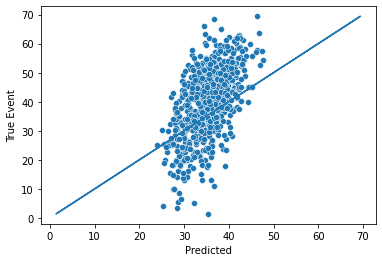

====> Train NLL: 67454.9839 	 Valid event loss: 124937.7334 	 censoring loss : 0.0000 	 Improved: *
epoch101
====> Train NLL: 60035.3591 	 Valid event loss: 111675.8422 	 censoring loss : 0.0000 	 Improved: *
epoch102
====> Train NLL: 54169.9253 	 Valid event loss: 101019.9471 	 censoring loss : 0.0000 	 Improved: *
epoch103
====> Train NLL: 49489.7307 	 Valid event loss: 92974.9714 	 censoring loss : 0.0000 	 Improved: *
epoch104
====> Train NLL: 46238.8563 	 Valid event loss: 87478.1377 	 censoring loss : 0.0000 	 Improved: *
epoch105
====> Train NLL: 44152.0094 	 Valid event loss: 84037.6593 	 censoring loss : 0.0000 	 Improved: *
epoch106
====> Train NLL: 42643.4060 	 Valid event loss: 81432.6337 	 censoring loss : 0.0000 	 Improved: *
epoch107
====> Train NLL: 41402.0843 	 Valid event loss: 79180.0730 	 censoring loss : 0.0000 	 Improved: *
epoch108
====> Train NLL: 40323.0377 	 Valid event loss: 77225.1811 	 censoring loss : 0.0000 	 Improved: *
epoch109
====> Train NLL: 39373.74

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


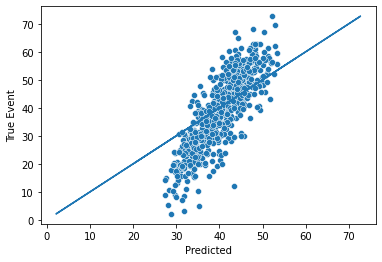

====> Train NLL: 38522.6628 	 Valid event loss: 73931.3332 	 censoring loss : 0.0000 	 Improved: *
epoch111
====> Train NLL: 37769.7574 	 Valid event loss: 72482.7478 	 censoring loss : 0.0000 	 Improved: *
epoch112
====> Train NLL: 37051.4887 	 Valid event loss: 71111.4171 	 censoring loss : 0.0000 	 Improved: *
epoch113
====> Train NLL: 36378.4690 	 Valid event loss: 69886.8956 	 censoring loss : 0.0000 	 Improved: *
epoch114
====> Train NLL: 35763.7302 	 Valid event loss: 68694.2241 	 censoring loss : 0.0000 	 Improved: *
epoch115
====> Train NLL: 35170.1305 	 Valid event loss: 67518.8791 	 censoring loss : 0.0000 	 Improved: *
epoch116
====> Train NLL: 34599.5588 	 Valid event loss: 66453.1141 	 censoring loss : 0.0000 	 Improved: *
epoch117
====> Train NLL: 34063.5771 	 Valid event loss: 65395.2540 	 censoring loss : 0.0000 	 Improved: *
epoch118
====> Train NLL: 33552.9301 	 Valid event loss: 64452.5502 	 censoring loss : 0.0000 	 Improved: *
epoch119
====> Train NLL: 33085.7769 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


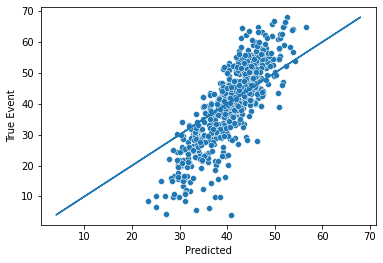

====> Train NLL: 32613.3751 	 Valid event loss: 62608.8024 	 censoring loss : 0.0000 	 Improved: *
epoch121
====> Train NLL: 32162.9297 	 Valid event loss: 61781.0670 	 censoring loss : 0.0000 	 Improved: *
epoch122
====> Train NLL: 31735.2181 	 Valid event loss: 60949.3856 	 censoring loss : 0.0000 	 Improved: *
epoch123
====> Train NLL: 31317.6721 	 Valid event loss: 60142.7609 	 censoring loss : 0.0000 	 Improved: *
epoch124
====> Train NLL: 30913.9492 	 Valid event loss: 59365.6931 	 censoring loss : 0.0000 	 Improved: *
epoch125
====> Train NLL: 30532.5898 	 Valid event loss: 58656.4811 	 censoring loss : 0.0000 	 Improved: *
epoch126
====> Train NLL: 30158.1786 	 Valid event loss: 57900.9573 	 censoring loss : 0.0000 	 Improved: *
epoch127
====> Train NLL: 29801.8187 	 Valid event loss: 57188.2686 	 censoring loss : 0.0000 	 Improved: *
epoch128
====> Train NLL: 29442.0117 	 Valid event loss: 56481.3504 	 censoring loss : 0.0000 	 Improved: *
epoch129
====> Train NLL: 29101.0360 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


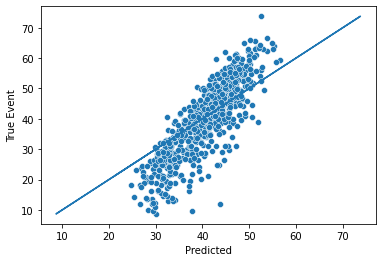

====> Train NLL: 28766.6870 	 Valid event loss: 55205.6439 	 censoring loss : 0.0000 	 Improved: *
epoch131
====> Train NLL: 28445.1572 	 Valid event loss: 54611.1674 	 censoring loss : 0.0000 	 Improved: *
epoch132
====> Train NLL: 28139.3383 	 Valid event loss: 54007.9459 	 censoring loss : 0.0000 	 Improved: *
epoch133
====> Train NLL: 27844.9680 	 Valid event loss: 53406.7988 	 censoring loss : 0.0000 	 Improved: *
epoch134
====> Train NLL: 27546.4691 	 Valid event loss: 52845.6121 	 censoring loss : 0.0000 	 Improved: *
epoch135
====> Train NLL: 27255.4995 	 Valid event loss: 52259.4288 	 censoring loss : 0.0000 	 Improved: *
epoch136
====> Train NLL: 26972.3650 	 Valid event loss: 51724.1175 	 censoring loss : 0.0000 	 Improved: *
epoch137
====> Train NLL: 26699.6259 	 Valid event loss: 51203.9716 	 censoring loss : 0.0000 	 Improved: *
epoch138
====> Train NLL: 26437.4556 	 Valid event loss: 50691.5530 	 censoring loss : 0.0000 	 Improved: *
epoch139
====> Train NLL: 26174.4916 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


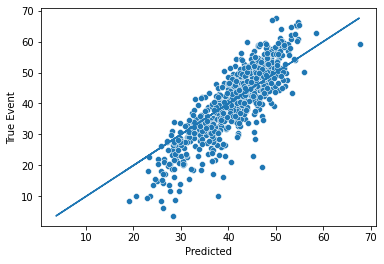

====> Train NLL: 25924.0017 	 Valid event loss: 49670.3029 	 censoring loss : 0.0000 	 Improved: *
epoch141
====> Train NLL: 25676.4669 	 Valid event loss: 49203.1904 	 censoring loss : 0.0000 	 Improved: *
epoch142
====> Train NLL: 25435.8075 	 Valid event loss: 48737.5396 	 censoring loss : 0.0000 	 Improved: *
epoch143
====> Train NLL: 25198.7536 	 Valid event loss: 48300.3485 	 censoring loss : 0.0000 	 Improved: *
epoch144
====> Train NLL: 24967.9929 	 Valid event loss: 47802.7878 	 censoring loss : 0.0000 	 Improved: *
epoch145
====> Train NLL: 24743.8039 	 Valid event loss: 47404.4467 	 censoring loss : 0.0000 	 Improved: *
epoch146
====> Train NLL: 24525.9182 	 Valid event loss: 46950.8294 	 censoring loss : 0.0000 	 Improved: *
epoch147
====> Train NLL: 24309.6560 	 Valid event loss: 46572.9822 	 censoring loss : 0.0000 	 Improved: *
epoch148
====> Train NLL: 24118.2240 	 Valid event loss: 46173.2169 	 censoring loss : 0.0000 	 Improved: *
epoch149
====> Train NLL: 23920.6238 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


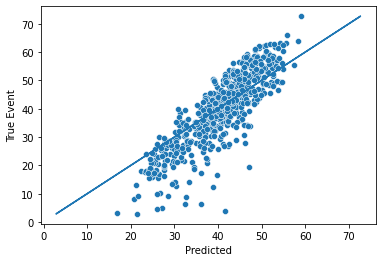

====> Train NLL: 23727.5132 	 Valid event loss: 45421.8891 	 censoring loss : 0.0000 	 Improved: *
epoch151
====> Train NLL: 23535.6743 	 Valid event loss: 45050.0745 	 censoring loss : 0.0000 	 Improved: *
epoch152
====> Train NLL: 23354.0617 	 Valid event loss: 44705.0317 	 censoring loss : 0.0000 	 Improved: *
epoch153
====> Train NLL: 23178.5090 	 Valid event loss: 44357.2802 	 censoring loss : 0.0000 	 Improved: *
epoch154
====> Train NLL: 23002.2044 	 Valid event loss: 44026.7690 	 censoring loss : 0.0000 	 Improved: *
epoch155
====> Train NLL: 22830.5500 	 Valid event loss: 43671.1821 	 censoring loss : 0.0000 	 Improved: *
epoch156
====> Train NLL: 22662.7113 	 Valid event loss: 43381.3938 	 censoring loss : 0.0000 	 Improved: *
epoch157
====> Train NLL: 22501.0040 	 Valid event loss: 43035.7285 	 censoring loss : 0.0000 	 Improved: *
epoch158
====> Train NLL: 22347.3416 	 Valid event loss: 42759.7730 	 censoring loss : 0.0000 	 Improved: *
epoch159
====> Train NLL: 22212.4608 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


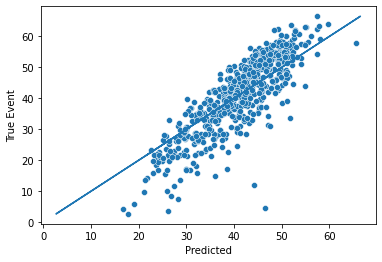

====> Train NLL: 22058.4616 	 Valid event loss: 42176.1778 	 censoring loss : 0.0000 	 Improved: *
epoch161
====> Train NLL: 21919.4635 	 Valid event loss: 41933.2520 	 censoring loss : 0.0000 	 Improved: *
epoch162
====> Train NLL: 21780.7017 	 Valid event loss: 41665.4632 	 censoring loss : 0.0000 	 Improved: *
epoch163
====> Train NLL: 21649.0055 	 Valid event loss: 41422.7631 	 censoring loss : 0.0000 	 Improved: *
epoch164
====> Train NLL: 21523.7431 	 Valid event loss: 41179.7993 	 censoring loss : 0.0000 	 Improved: *
epoch165
====> Train NLL: 21399.0721 	 Valid event loss: 40945.6596 	 censoring loss : 0.0000 	 Improved: *
epoch166
====> Train NLL: 21287.8902 	 Valid event loss: 40723.7619 	 censoring loss : 0.0000 	 Improved: *
epoch167
====> Train NLL: 21172.0983 	 Valid event loss: 40487.6482 	 censoring loss : 0.0000 	 Improved: *
epoch168
====> Train NLL: 21061.9405 	 Valid event loss: 40308.6343 	 censoring loss : 0.0000 	 Improved: *
epoch169
====> Train NLL: 20953.0302 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


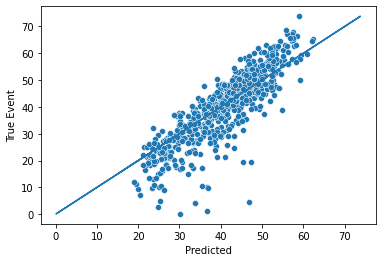

====> Train NLL: 20852.2344 	 Valid event loss: 39859.0304 	 censoring loss : 0.0000 	 Improved: *
epoch171
====> Train NLL: 20747.9353 	 Valid event loss: 39677.9522 	 censoring loss : 0.0000 	 Improved: *
epoch172
====> Train NLL: 20649.2013 	 Valid event loss: 39493.5276 	 censoring loss : 0.0000 	 Improved: *
epoch173
====> Train NLL: 20555.3460 	 Valid event loss: 39312.6826 	 censoring loss : 0.0000 	 Improved: *
epoch174
====> Train NLL: 20464.7042 	 Valid event loss: 39145.0359 	 censoring loss : 0.0000 	 Improved: *
epoch175
====> Train NLL: 20383.0283 	 Valid event loss: 38981.9072 	 censoring loss : 0.0000 	 Improved: *
epoch176
====> Train NLL: 20299.8230 	 Valid event loss: 38826.8672 	 censoring loss : 0.0000 	 Improved: *
epoch177
====> Train NLL: 20219.2477 	 Valid event loss: 38657.7560 	 censoring loss : 0.0000 	 Improved: *
epoch178
====> Train NLL: 20143.4831 	 Valid event loss: 38517.8480 	 censoring loss : 0.0000 	 Improved: *
epoch179
====> Train NLL: 20064.9256 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


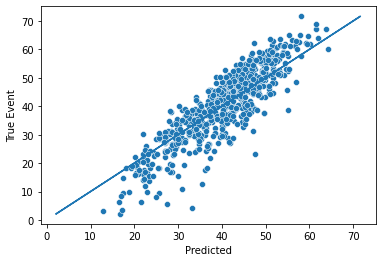

====> Train NLL: 20001.4324 	 Valid event loss: 38281.3626 	 censoring loss : 0.0000 	 Improved: *
epoch181
====> Train NLL: 19933.7130 	 Valid event loss: 38140.5574 	 censoring loss : 0.0000 	 Improved: *
epoch182
====> Train NLL: 19870.2543 	 Valid event loss: 38016.6554 	 censoring loss : 0.0000 	 Improved: *
epoch183
====> Train NLL: 19806.2627 	 Valid event loss: 37889.1573 	 censoring loss : 0.0000 	 Improved: *
epoch184
====> Train NLL: 19745.7604 	 Valid event loss: 37786.2442 	 censoring loss : 0.0000 	 Improved: *
epoch185
====> Train NLL: 19695.0189 	 Valid event loss: 37703.3585 	 censoring loss : 0.0000 	 Improved: *
epoch186
====> Train NLL: 19643.2392 	 Valid event loss: 37570.5662 	 censoring loss : 0.0000 	 Improved: *
epoch187
====> Train NLL: 19583.4904 	 Valid event loss: 37471.4078 	 censoring loss : 0.0000 	 Improved: *
epoch188
====> Train NLL: 19531.6441 	 Valid event loss: 37382.1698 	 censoring loss : 0.0000 	 Improved: *
epoch189
====> Train NLL: 19482.3007 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


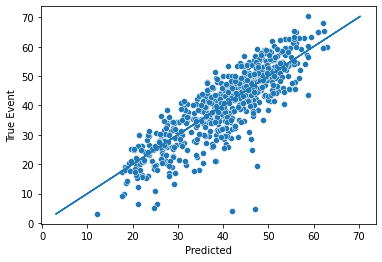

====> Train NLL: 19439.2807 	 Valid event loss: 37208.9546 	 censoring loss : 0.0000 	 Improved: *
epoch191
====> Train NLL: 19393.7960 	 Valid event loss: 37117.7684 	 censoring loss : 0.0000 	 Improved: *
epoch192
====> Train NLL: 19354.2390 	 Valid event loss: 37047.1405 	 censoring loss : 0.0000 	 Improved: *
epoch193
====> Train NLL: 19313.2693 	 Valid event loss: 36964.0361 	 censoring loss : 0.0000 	 Improved: *
epoch194
====> Train NLL: 19273.8495 	 Valid event loss: 36888.7884 	 censoring loss : 0.0000 	 Improved: *
epoch195
====> Train NLL: 19230.7847 	 Valid event loss: 36849.7835 	 censoring loss : 0.0000 	 Improved: *
epoch196
====> Train NLL: 19200.5925 	 Valid event loss: 36790.0609 	 censoring loss : 0.0000 	 Improved: *
epoch197
====> Train NLL: 19175.1858 	 Valid event loss: 36718.0596 	 censoring loss : 0.0000 	 Improved: *
epoch198
====> Train NLL: 19140.5061 	 Valid event loss: 36661.8352 	 censoring loss : 0.0000 	 Improved: *
epoch199
====> Train NLL: 19102.0377 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


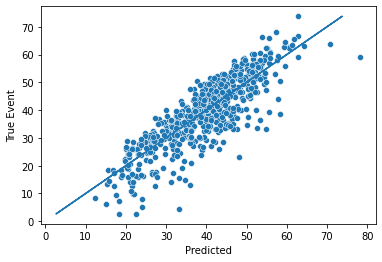

====> Train NLL: 19073.3644 	 Valid event loss: 36532.7749 	 censoring loss : 0.0000 	 Improved: *
epoch201
====> Train NLL: 19043.4666 	 Valid event loss: 36494.2544 	 censoring loss : 0.0000 	 Improved: *
epoch202
====> Train NLL: 19011.7541 	 Valid event loss: 36428.2680 	 censoring loss : 0.0000 	 Improved: *
epoch203
====> Train NLL: 18990.8149 	 Valid event loss: 36425.4075 	 censoring loss : 0.0000 	 Improved: *
epoch204
====> Train NLL: 18971.1785 	 Valid event loss: 36341.2826 	 censoring loss : 0.0000 	 Improved: *
epoch205
====> Train NLL: 18938.0815 	 Valid event loss: 36306.9643 	 censoring loss : 0.0000 	 Improved: *
epoch206
====> Train NLL: 18912.7294 	 Valid event loss: 36263.8409 	 censoring loss : 0.0000 	 Improved: *
epoch207
====> Train NLL: 18893.8741 	 Valid event loss: 36217.8145 	 censoring loss : 0.0000 	 Improved: *
epoch208
====> Train NLL: 18872.2945 	 Valid event loss: 36187.4349 	 censoring loss : 0.0000 	 Improved: *
epoch209
====> Train NLL: 18849.0885 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


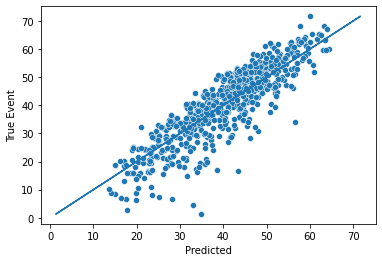

====> Train NLL: 18833.0791 	 Valid event loss: 36131.5305 	 censoring loss : 0.0000 	 Improved: *
epoch211
====> Train NLL: 18813.6686 	 Valid event loss: 36069.6028 	 censoring loss : 0.0000 	 Improved: *
epoch212
====> Train NLL: 18793.1296 	 Valid event loss: 36047.3138 	 censoring loss : 0.0000 	 Improved: *
epoch213
====> Train NLL: 18779.2849 	 Valid event loss: 36048.1729 	 censoring loss : 0.0000 	 Improved:  
epoch214
====> Train NLL: 18758.4736 	 Valid event loss: 35991.6567 	 censoring loss : 0.0000 	 Improved: *
epoch215
====> Train NLL: 18746.1983 	 Valid event loss: 35956.7791 	 censoring loss : 0.0000 	 Improved: *
epoch216
====> Train NLL: 18725.8962 	 Valid event loss: 35942.7416 	 censoring loss : 0.0000 	 Improved: *
epoch217
====> Train NLL: 18711.1069 	 Valid event loss: 35903.1279 	 censoring loss : 0.0000 	 Improved: *
epoch218
====> Train NLL: 18698.2531 	 Valid event loss: 35889.4093 	 censoring loss : 0.0000 	 Improved: *
epoch219
====> Train NLL: 18685.4292 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


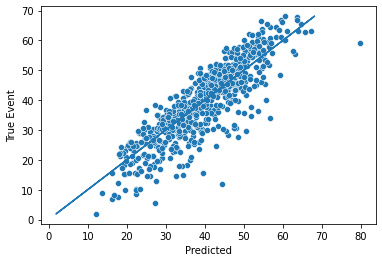

====> Train NLL: 18669.1416 	 Valid event loss: 35853.8780 	 censoring loss : 0.0000 	 Improved: *
epoch221
====> Train NLL: 18660.6455 	 Valid event loss: 35841.8377 	 censoring loss : 0.0000 	 Improved: *
epoch222
====> Train NLL: 18646.8831 	 Valid event loss: 35811.0889 	 censoring loss : 0.0000 	 Improved: *
epoch223
====> Train NLL: 18636.2752 	 Valid event loss: 35793.8105 	 censoring loss : 0.0000 	 Improved: *
epoch224
====> Train NLL: 18622.8555 	 Valid event loss: 35770.2240 	 censoring loss : 0.0000 	 Improved: *
epoch225
====> Train NLL: 18610.1972 	 Valid event loss: 35744.9877 	 censoring loss : 0.0000 	 Improved: *
epoch226
====> Train NLL: 18605.3831 	 Valid event loss: 35735.6688 	 censoring loss : 0.0000 	 Improved: *
epoch227
====> Train NLL: 18588.6308 	 Valid event loss: 35715.4854 	 censoring loss : 0.0000 	 Improved: *
epoch228
====> Train NLL: 18577.1831 	 Valid event loss: 35715.8009 	 censoring loss : 0.0000 	 Improved:  
epoch229
====> Train NLL: 18567.8155 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


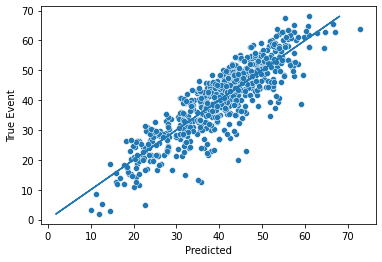

====> Train NLL: 18558.5453 	 Valid event loss: 35672.5485 	 censoring loss : 0.0000 	 Improved: *
epoch231
====> Train NLL: 18550.7566 	 Valid event loss: 35668.7479 	 censoring loss : 0.0000 	 Improved: *
epoch232
====> Train NLL: 18543.7263 	 Valid event loss: 35650.6624 	 censoring loss : 0.0000 	 Improved: *
epoch233
====> Train NLL: 18537.7617 	 Valid event loss: 35660.5836 	 censoring loss : 0.0000 	 Improved:  
epoch234
====> Train NLL: 18528.7887 	 Valid event loss: 35655.3394 	 censoring loss : 0.0000 	 Improved:  
epoch235
====> Train NLL: 18518.6050 	 Valid event loss: 35637.9181 	 censoring loss : 0.0000 	 Improved: *
epoch236
====> Train NLL: 18512.0566 	 Valid event loss: 35619.7854 	 censoring loss : 0.0000 	 Improved: *
epoch237
====> Train NLL: 18505.4887 	 Valid event loss: 35614.5611 	 censoring loss : 0.0000 	 Improved: *
epoch238
====> Train NLL: 18494.9341 	 Valid event loss: 35593.1666 	 censoring loss : 0.0000 	 Improved: *
epoch239
====> Train NLL: 18488.2231 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


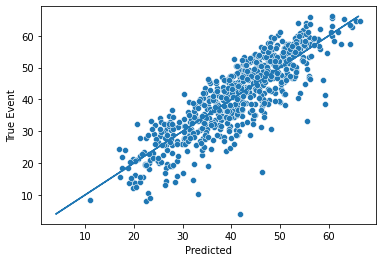

====> Train NLL: 18480.6010 	 Valid event loss: 35579.7865 	 censoring loss : 0.0000 	 Improved: *
epoch241
====> Train NLL: 18476.4878 	 Valid event loss: 35557.4930 	 censoring loss : 0.0000 	 Improved: *
epoch242
====> Train NLL: 18468.7711 	 Valid event loss: 35554.3741 	 censoring loss : 0.0000 	 Improved: *
epoch243
====> Train NLL: 18462.3284 	 Valid event loss: 35569.1955 	 censoring loss : 0.0000 	 Improved:  
epoch244
====> Train NLL: 18455.1824 	 Valid event loss: 35550.7761 	 censoring loss : 0.0000 	 Improved: *
epoch245
====> Train NLL: 18452.2062 	 Valid event loss: 35543.4088 	 censoring loss : 0.0000 	 Improved: *
epoch246
====> Train NLL: 18448.8241 	 Valid event loss: 35534.0155 	 censoring loss : 0.0000 	 Improved: *
epoch247
====> Train NLL: 18436.9091 	 Valid event loss: 35524.5246 	 censoring loss : 0.0000 	 Improved: *
epoch248
====> Train NLL: 18430.9801 	 Valid event loss: 35512.7144 	 censoring loss : 0.0000 	 Improved: *
epoch249
====> Train NLL: 18423.5741 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


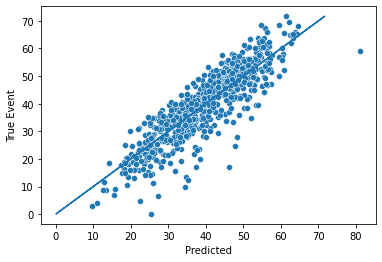

====> Train NLL: 18418.7819 	 Valid event loss: 35494.9736 	 censoring loss : 0.0000 	 Improved: *
epoch251
====> Train NLL: 18417.2414 	 Valid event loss: 35513.3909 	 censoring loss : 0.0000 	 Improved:  
epoch252
====> Train NLL: 18408.7189 	 Valid event loss: 35490.9170 	 censoring loss : 0.0000 	 Improved: *
epoch253
====> Train NLL: 18402.4287 	 Valid event loss: 35492.0347 	 censoring loss : 0.0000 	 Improved:  
epoch254
====> Train NLL: 18397.8423 	 Valid event loss: 35476.9350 	 censoring loss : 0.0000 	 Improved: *
epoch255
====> Train NLL: 18392.2379 	 Valid event loss: 35455.6416 	 censoring loss : 0.0000 	 Improved: *
epoch256
====> Train NLL: 18389.4517 	 Valid event loss: 35485.2498 	 censoring loss : 0.0000 	 Improved:  
epoch257
====> Train NLL: 18390.1897 	 Valid event loss: 35522.2763 	 censoring loss : 0.0000 	 Improved:  
epoch258
====> Train NLL: 18382.6650 	 Valid event loss: 35454.7755 	 censoring loss : 0.0000 	 Improved: *
epoch259
====> Train NLL: 18377.8726 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


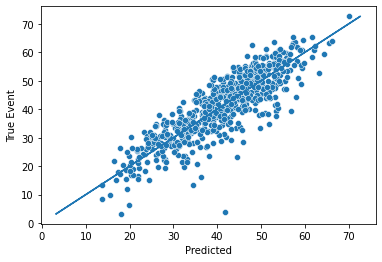

====> Train NLL: 18372.7221 	 Valid event loss: 35454.4357 	 censoring loss : 0.0000 	 Improved:  
epoch261
====> Train NLL: 18365.6413 	 Valid event loss: 35448.5364 	 censoring loss : 0.0000 	 Improved:  
epoch262
====> Train NLL: 18361.1070 	 Valid event loss: 35428.8944 	 censoring loss : 0.0000 	 Improved: *
epoch263
====> Train NLL: 18355.2849 	 Valid event loss: 35427.0083 	 censoring loss : 0.0000 	 Improved: *
epoch264
====> Train NLL: 18356.2439 	 Valid event loss: 35428.4514 	 censoring loss : 0.0000 	 Improved:  
epoch265
====> Train NLL: 18352.1368 	 Valid event loss: 35434.4972 	 censoring loss : 0.0000 	 Improved:  
epoch266
====> Train NLL: 18345.1566 	 Valid event loss: 35405.5075 	 censoring loss : 0.0000 	 Improved: *
epoch267
====> Train NLL: 18339.9682 	 Valid event loss: 35407.2445 	 censoring loss : 0.0000 	 Improved:  
epoch268
====> Train NLL: 18335.4849 	 Valid event loss: 35409.0563 	 censoring loss : 0.0000 	 Improved:  
epoch269
====> Train NLL: 18331.5244 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


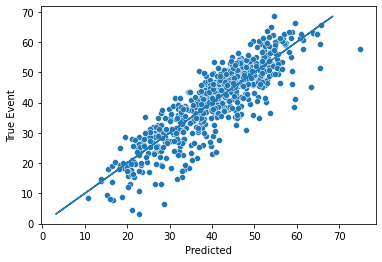

====> Train NLL: 18325.6788 	 Valid event loss: 35429.4840 	 censoring loss : 0.0000 	 Improved:  
epoch271
====> Train NLL: 18323.4733 	 Valid event loss: 35403.3668 	 censoring loss : 0.0000 	 Improved:  
epoch272
====> Train NLL: 18322.3971 	 Valid event loss: 35398.4777 	 censoring loss : 0.0000 	 Improved: *
epoch273
====> Train NLL: 18315.2016 	 Valid event loss: 35401.0673 	 censoring loss : 0.0000 	 Improved:  
epoch274
====> Train NLL: 18311.9287 	 Valid event loss: 35396.9550 	 censoring loss : 0.0000 	 Improved: *
epoch275
====> Train NLL: 18307.1385 	 Valid event loss: 35386.0377 	 censoring loss : 0.0000 	 Improved: *
epoch276
====> Train NLL: 18312.4613 	 Valid event loss: 35395.2149 	 censoring loss : 0.0000 	 Improved:  
epoch277
====> Train NLL: 18299.0347 	 Valid event loss: 35370.4014 	 censoring loss : 0.0000 	 Improved: *
epoch278
====> Train NLL: 18296.1077 	 Valid event loss: 35382.4982 	 censoring loss : 0.0000 	 Improved:  
epoch279
====> Train NLL: 18293.6217 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


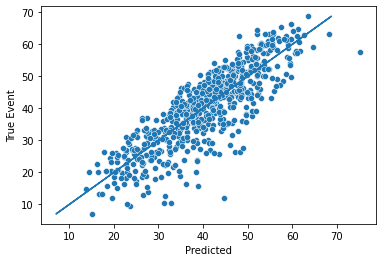

====> Train NLL: 18291.9038 	 Valid event loss: 35362.0346 	 censoring loss : 0.0000 	 Improved: *
epoch281
====> Train NLL: 18284.8046 	 Valid event loss: 35358.2785 	 censoring loss : 0.0000 	 Improved: *
epoch282
====> Train NLL: 18281.6313 	 Valid event loss: 35367.1523 	 censoring loss : 0.0000 	 Improved:  
epoch283
====> Train NLL: 18279.5764 	 Valid event loss: 35342.7760 	 censoring loss : 0.0000 	 Improved: *
epoch284
====> Train NLL: 18276.9468 	 Valid event loss: 35353.9593 	 censoring loss : 0.0000 	 Improved:  
epoch285
====> Train NLL: 18270.3299 	 Valid event loss: 35338.2414 	 censoring loss : 0.0000 	 Improved: *
epoch286
====> Train NLL: 18270.9745 	 Valid event loss: 35368.6978 	 censoring loss : 0.0000 	 Improved:  
epoch287
====> Train NLL: 18272.9360 	 Valid event loss: 35339.7295 	 censoring loss : 0.0000 	 Improved:  
epoch288
====> Train NLL: 18264.9542 	 Valid event loss: 35331.7644 	 censoring loss : 0.0000 	 Improved: *
epoch289
====> Train NLL: 18261.0199 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


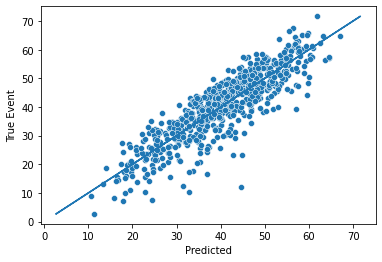

====> Train NLL: 18259.9160 	 Valid event loss: 35333.2309 	 censoring loss : 0.0000 	 Improved:  
epoch291
====> Train NLL: 18252.4114 	 Valid event loss: 35333.8458 	 censoring loss : 0.0000 	 Improved:  
epoch292
====> Train NLL: 18248.1899 	 Valid event loss: 35327.6566 	 censoring loss : 0.0000 	 Improved: *
epoch293
====> Train NLL: 18243.9984 	 Valid event loss: 35346.4513 	 censoring loss : 0.0000 	 Improved:  
epoch294
====> Train NLL: 18250.1774 	 Valid event loss: 35319.6470 	 censoring loss : 0.0000 	 Improved: *
epoch295
====> Train NLL: 18238.9686 	 Valid event loss: 35358.0891 	 censoring loss : 0.0000 	 Improved:  
epoch296
====> Train NLL: 18236.2531 	 Valid event loss: 35300.7545 	 censoring loss : 0.0000 	 Improved: *
epoch297
====> Train NLL: 18237.3755 	 Valid event loss: 35304.6271 	 censoring loss : 0.0000 	 Improved:  
epoch298
====> Train NLL: 18230.7559 	 Valid event loss: 35318.8970 	 censoring loss : 0.0000 	 Improved:  
epoch299
====> Train NLL: 18231.5519 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


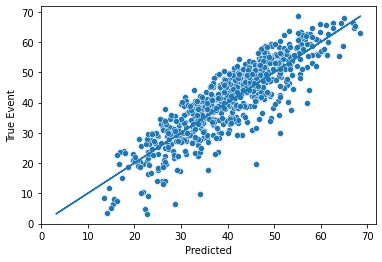

====> Train NLL: 18230.2075 	 Valid event loss: 35307.2428 	 censoring loss : 0.0000 	 Improved:  
epoch301
====> Train NLL: 18221.8742 	 Valid event loss: 35290.0248 	 censoring loss : 0.0000 	 Improved: *
epoch302
====> Train NLL: 18218.8069 	 Valid event loss: 35318.3844 	 censoring loss : 0.0000 	 Improved:  
epoch303
====> Train NLL: 18216.6678 	 Valid event loss: 35317.2831 	 censoring loss : 0.0000 	 Improved:  
epoch304
====> Train NLL: 18210.2682 	 Valid event loss: 35295.8215 	 censoring loss : 0.0000 	 Improved:  
epoch305
====> Train NLL: 18210.1563 	 Valid event loss: 35288.1903 	 censoring loss : 0.0000 	 Improved: *
epoch306
====> Train NLL: 18206.7130 	 Valid event loss: 35312.8923 	 censoring loss : 0.0000 	 Improved:  
epoch307
====> Train NLL: 18201.3433 	 Valid event loss: 35273.4933 	 censoring loss : 0.0000 	 Improved: *
epoch308
====> Train NLL: 18200.1626 	 Valid event loss: 35287.4322 	 censoring loss : 0.0000 	 Improved:  
epoch309
====> Train NLL: 18195.0972 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


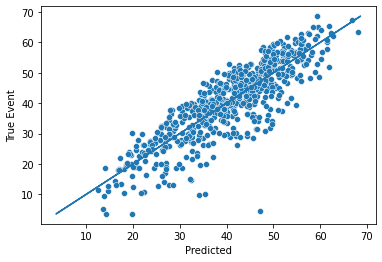

====> Train NLL: 18193.9233 	 Valid event loss: 35305.2964 	 censoring loss : 0.0000 	 Improved:  
epoch311
====> Train NLL: 18191.4116 	 Valid event loss: 35288.2849 	 censoring loss : 0.0000 	 Improved:  
epoch312
====> Train NLL: 18188.3046 	 Valid event loss: 35292.9200 	 censoring loss : 0.0000 	 Improved:  
epoch313
====> Train NLL: 18184.7468 	 Valid event loss: 35276.1253 	 censoring loss : 0.0000 	 Improved:  
epoch314
====> Train NLL: 18180.3402 	 Valid event loss: 35265.7823 	 censoring loss : 0.0000 	 Improved: *
epoch315
====> Train NLL: 18181.6451 	 Valid event loss: 35286.1801 	 censoring loss : 0.0000 	 Improved:  
epoch316
====> Train NLL: 18176.2364 	 Valid event loss: 35260.7174 	 censoring loss : 0.0000 	 Improved: *
epoch317
====> Train NLL: 18171.0260 	 Valid event loss: 35280.9785 	 censoring loss : 0.0000 	 Improved:  
epoch318
====> Train NLL: 18172.2043 	 Valid event loss: 35252.3592 	 censoring loss : 0.0000 	 Improved: *
epoch319
====> Train NLL: 18165.4887 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


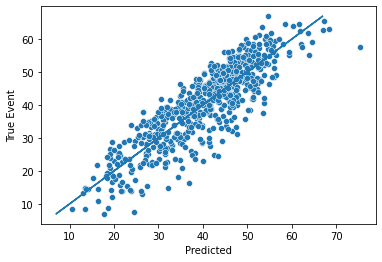

====> Train NLL: 18166.3886 	 Valid event loss: 35264.1246 	 censoring loss : 0.0000 	 Improved:  
epoch321
====> Train NLL: 18160.5104 	 Valid event loss: 35246.5850 	 censoring loss : 0.0000 	 Improved: *
epoch322
====> Train NLL: 18157.1579 	 Valid event loss: 35261.7471 	 censoring loss : 0.0000 	 Improved:  
epoch323
====> Train NLL: 18154.5867 	 Valid event loss: 35266.9133 	 censoring loss : 0.0000 	 Improved:  
epoch324
====> Train NLL: 18154.8160 	 Valid event loss: 35257.8090 	 censoring loss : 0.0000 	 Improved:  
epoch325
====> Train NLL: 18151.9655 	 Valid event loss: 35266.3294 	 censoring loss : 0.0000 	 Improved:  
epoch326
====> Train NLL: 18148.8102 	 Valid event loss: 35259.1945 	 censoring loss : 0.0000 	 Improved:  
epoch327
====> Train NLL: 18143.3208 	 Valid event loss: 35245.3180 	 censoring loss : 0.0000 	 Improved: *
epoch328
====> Train NLL: 18141.3994 	 Valid event loss: 35234.4293 	 censoring loss : 0.0000 	 Improved: *
epoch329
====> Train NLL: 18138.8230 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


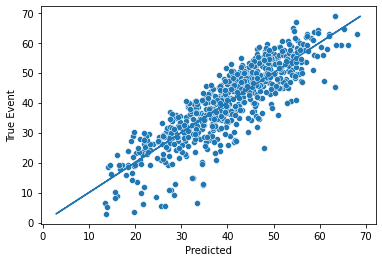

====> Train NLL: 18135.9563 	 Valid event loss: 35236.2193 	 censoring loss : 0.0000 	 Improved:  
epoch331
====> Train NLL: 18133.2224 	 Valid event loss: 35239.5724 	 censoring loss : 0.0000 	 Improved:  
epoch332
====> Train NLL: 18131.2184 	 Valid event loss: 35235.7332 	 censoring loss : 0.0000 	 Improved:  
epoch333
====> Train NLL: 18128.1140 	 Valid event loss: 35235.0217 	 censoring loss : 0.0000 	 Improved:  
epoch334
====> Train NLL: 18124.1960 	 Valid event loss: 35219.4080 	 censoring loss : 0.0000 	 Improved: *
epoch335
====> Train NLL: 18121.4424 	 Valid event loss: 35250.3801 	 censoring loss : 0.0000 	 Improved:  
epoch336
====> Train NLL: 18123.3159 	 Valid event loss: 35211.3305 	 censoring loss : 0.0000 	 Improved: *
epoch337
====> Train NLL: 18120.8768 	 Valid event loss: 35249.6592 	 censoring loss : 0.0000 	 Improved:  
epoch338
====> Train NLL: 18113.6349 	 Valid event loss: 35204.5636 	 censoring loss : 0.0000 	 Improved: *
epoch339
====> Train NLL: 18115.5237 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


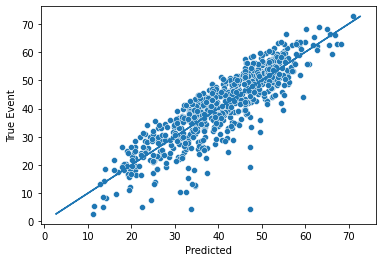

====> Train NLL: 18107.8977 	 Valid event loss: 35221.6454 	 censoring loss : 0.0000 	 Improved:  
epoch341
====> Train NLL: 18105.0575 	 Valid event loss: 35212.4336 	 censoring loss : 0.0000 	 Improved:  
epoch342
====> Train NLL: 18103.3178 	 Valid event loss: 35214.4999 	 censoring loss : 0.0000 	 Improved:  
epoch343
====> Train NLL: 18104.3072 	 Valid event loss: 35218.8849 	 censoring loss : 0.0000 	 Improved:  
epoch344
====> Train NLL: 18099.6157 	 Valid event loss: 35243.5004 	 censoring loss : 0.0000 	 Improved:  
epoch345
====> Train NLL: 18096.9318 	 Valid event loss: 35220.7953 	 censoring loss : 0.0000 	 Improved:  
epoch346
====> Train NLL: 18092.5304 	 Valid event loss: 35243.1274 	 censoring loss : 0.0000 	 Improved:  
epoch347
====> Train NLL: 18091.7680 	 Valid event loss: 35213.9217 	 censoring loss : 0.0000 	 Improved:  
epoch348
====> Train NLL: 18089.2700 	 Valid event loss: 35193.6210 	 censoring loss : 0.0000 	 Improved: *
epoch349
====> Train NLL: 18089.3700 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


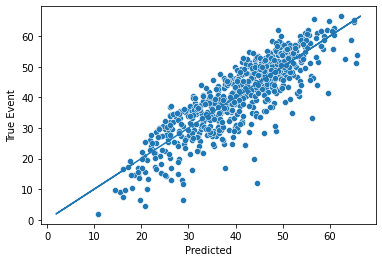

====> Train NLL: 18084.4520 	 Valid event loss: 35218.6332 	 censoring loss : 0.0000 	 Improved:  
epoch351
====> Train NLL: 18080.8352 	 Valid event loss: 35179.1955 	 censoring loss : 0.0000 	 Improved: *
epoch352
====> Train NLL: 18076.4178 	 Valid event loss: 35211.2415 	 censoring loss : 0.0000 	 Improved:  
epoch353
====> Train NLL: 18076.6358 	 Valid event loss: 35192.9671 	 censoring loss : 0.0000 	 Improved:  
epoch354
====> Train NLL: 18074.5427 	 Valid event loss: 35228.4673 	 censoring loss : 0.0000 	 Improved:  
epoch355
====> Train NLL: 18073.6102 	 Valid event loss: 35175.1161 	 censoring loss : 0.0000 	 Improved: *
epoch356
====> Train NLL: 18066.4367 	 Valid event loss: 35187.4303 	 censoring loss : 0.0000 	 Improved:  
epoch357
====> Train NLL: 18063.6814 	 Valid event loss: 35187.8940 	 censoring loss : 0.0000 	 Improved:  
epoch358
====> Train NLL: 18062.4866 	 Valid event loss: 35192.4341 	 censoring loss : 0.0000 	 Improved:  
epoch359
====> Train NLL: 18061.8244 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


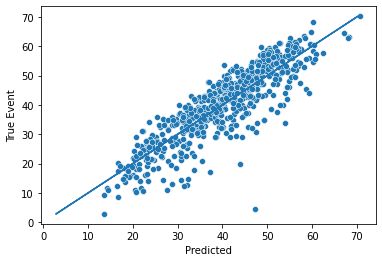

====> Train NLL: 18057.2601 	 Valid event loss: 35191.7344 	 censoring loss : 0.0000 	 Improved:  
epoch361
====> Train NLL: 18053.6224 	 Valid event loss: 35171.6954 	 censoring loss : 0.0000 	 Improved: *
epoch362
====> Train NLL: 18056.1181 	 Valid event loss: 35194.3733 	 censoring loss : 0.0000 	 Improved:  
epoch363
====> Train NLL: 18051.4497 	 Valid event loss: 35164.2894 	 censoring loss : 0.0000 	 Improved: *
epoch364
====> Train NLL: 18050.2800 	 Valid event loss: 35166.2743 	 censoring loss : 0.0000 	 Improved:  
epoch365
====> Train NLL: 18044.7115 	 Valid event loss: 35164.2677 	 censoring loss : 0.0000 	 Improved: *
epoch366
====> Train NLL: 18045.6468 	 Valid event loss: 35170.1308 	 censoring loss : 0.0000 	 Improved:  
epoch367
====> Train NLL: 18039.4762 	 Valid event loss: 35163.0129 	 censoring loss : 0.0000 	 Improved: *
epoch368
====> Train NLL: 18039.2505 	 Valid event loss: 35170.9569 	 censoring loss : 0.0000 	 Improved:  
epoch369
====> Train NLL: 18033.9188 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


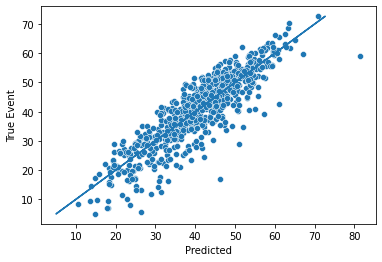

====> Train NLL: 18032.9922 	 Valid event loss: 35156.4554 	 censoring loss : 0.0000 	 Improved: *
epoch371
====> Train NLL: 18030.8394 	 Valid event loss: 35177.8607 	 censoring loss : 0.0000 	 Improved:  
epoch372
====> Train NLL: 18026.6635 	 Valid event loss: 35161.2361 	 censoring loss : 0.0000 	 Improved:  
epoch373
====> Train NLL: 18026.2301 	 Valid event loss: 35149.8397 	 censoring loss : 0.0000 	 Improved: *
epoch374
====> Train NLL: 18022.5776 	 Valid event loss: 35166.5391 	 censoring loss : 0.0000 	 Improved:  
epoch375
====> Train NLL: 18019.6993 	 Valid event loss: 35145.7572 	 censoring loss : 0.0000 	 Improved: *
epoch376
====> Train NLL: 18020.1670 	 Valid event loss: 35137.1447 	 censoring loss : 0.0000 	 Improved: *
epoch377
====> Train NLL: 18014.9511 	 Valid event loss: 35155.3016 	 censoring loss : 0.0000 	 Improved:  
epoch378
====> Train NLL: 18013.2177 	 Valid event loss: 35157.6415 	 censoring loss : 0.0000 	 Improved:  
epoch379
====> Train NLL: 18011.7713 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


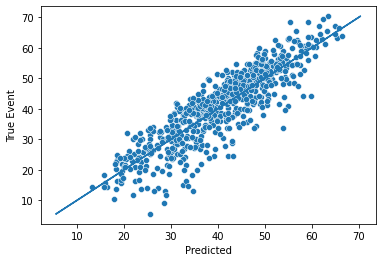

====> Train NLL: 18010.5116 	 Valid event loss: 35152.3410 	 censoring loss : 0.0000 	 Improved:  
epoch381
====> Train NLL: 18006.1832 	 Valid event loss: 35144.9157 	 censoring loss : 0.0000 	 Improved:  
epoch382
====> Train NLL: 18003.4924 	 Valid event loss: 35134.4837 	 censoring loss : 0.0000 	 Improved: *
epoch383
====> Train NLL: 18000.1852 	 Valid event loss: 35135.9293 	 censoring loss : 0.0000 	 Improved:  
epoch384
====> Train NLL: 18003.1426 	 Valid event loss: 35129.9427 	 censoring loss : 0.0000 	 Improved: *
epoch385
====> Train NLL: 18002.9555 	 Valid event loss: 35129.4274 	 censoring loss : 0.0000 	 Improved: *
epoch386
====> Train NLL: 18009.6654 	 Valid event loss: 35122.2804 	 censoring loss : 0.0000 	 Improved: *
epoch387
====> Train NLL: 17993.2904 	 Valid event loss: 35126.7742 	 censoring loss : 0.0000 	 Improved:  
epoch388
====> Train NLL: 17992.8881 	 Valid event loss: 35125.3702 	 censoring loss : 0.0000 	 Improved:  
epoch389
====> Train NLL: 17987.7896 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


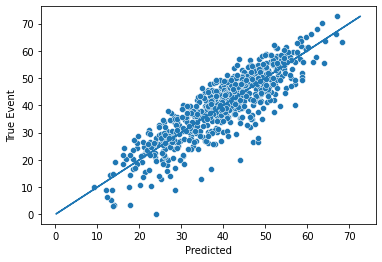

====> Train NLL: 17985.6853 	 Valid event loss: 35129.3801 	 censoring loss : 0.0000 	 Improved:  
epoch391
====> Train NLL: 17982.4734 	 Valid event loss: 35114.1929 	 censoring loss : 0.0000 	 Improved: *
epoch392
====> Train NLL: 17981.0433 	 Valid event loss: 35120.9989 	 censoring loss : 0.0000 	 Improved:  
epoch393
====> Train NLL: 17977.6956 	 Valid event loss: 35114.9834 	 censoring loss : 0.0000 	 Improved:  
epoch394
====> Train NLL: 17980.2505 	 Valid event loss: 35145.3033 	 censoring loss : 0.0000 	 Improved:  
epoch395
====> Train NLL: 17972.3434 	 Valid event loss: 35112.9534 	 censoring loss : 0.0000 	 Improved: *
epoch396
====> Train NLL: 17972.6678 	 Valid event loss: 35147.7950 	 censoring loss : 0.0000 	 Improved:  
epoch397
====> Train NLL: 17969.7296 	 Valid event loss: 35123.2861 	 censoring loss : 0.0000 	 Improved:  
epoch398
====> Train NLL: 17968.9810 	 Valid event loss: 35107.8483 	 censoring loss : 0.0000 	 Improved: *
epoch399
====> Train NLL: 17965.7273 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


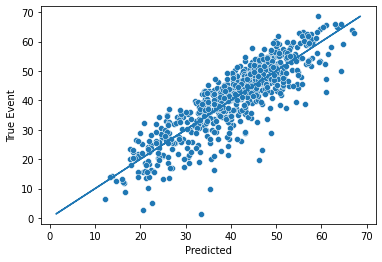

====> Train NLL: 17967.7657 	 Valid event loss: 35102.2194 	 censoring loss : 0.0000 	 Improved: *
epoch401
====> Train NLL: 17960.3485 	 Valid event loss: 35123.9406 	 censoring loss : 0.0000 	 Improved:  
epoch402
====> Train NLL: 17960.0749 	 Valid event loss: 35134.8349 	 censoring loss : 0.0000 	 Improved:  
epoch403
====> Train NLL: 17955.2623 	 Valid event loss: 35101.7758 	 censoring loss : 0.0000 	 Improved: *
epoch404
====> Train NLL: 17953.3353 	 Valid event loss: 35098.4163 	 censoring loss : 0.0000 	 Improved: *
epoch405
====> Train NLL: 17956.2676 	 Valid event loss: 35093.2294 	 censoring loss : 0.0000 	 Improved: *
epoch406
====> Train NLL: 17953.3117 	 Valid event loss: 35112.3309 	 censoring loss : 0.0000 	 Improved:  
epoch407
====> Train NLL: 17948.6510 	 Valid event loss: 35089.6724 	 censoring loss : 0.0000 	 Improved: *
epoch408
====> Train NLL: 17945.4127 	 Valid event loss: 35121.9901 	 censoring loss : 0.0000 	 Improved:  
epoch409
====> Train NLL: 17945.2865 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


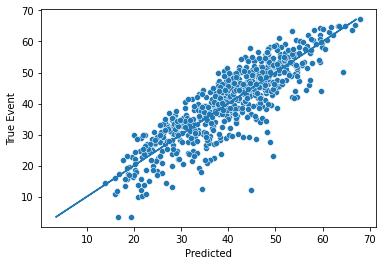

====> Train NLL: 17939.9882 	 Valid event loss: 35110.4805 	 censoring loss : 0.0000 	 Improved:  
epoch411
====> Train NLL: 17940.4826 	 Valid event loss: 35100.9554 	 censoring loss : 0.0000 	 Improved:  
epoch412
====> Train NLL: 17936.8191 	 Valid event loss: 35118.2530 	 censoring loss : 0.0000 	 Improved:  
epoch413
====> Train NLL: 17936.7677 	 Valid event loss: 35098.7232 	 censoring loss : 0.0000 	 Improved:  
epoch414
====> Train NLL: 17932.7305 	 Valid event loss: 35083.9739 	 censoring loss : 0.0000 	 Improved: *
epoch415
====> Train NLL: 17929.7289 	 Valid event loss: 35083.9638 	 censoring loss : 0.0000 	 Improved: *
epoch416
====> Train NLL: 17926.2844 	 Valid event loss: 35095.0744 	 censoring loss : 0.0000 	 Improved:  
epoch417
====> Train NLL: 17929.0533 	 Valid event loss: 35082.3243 	 censoring loss : 0.0000 	 Improved: *
epoch418
====> Train NLL: 17924.2552 	 Valid event loss: 35076.6964 	 censoring loss : 0.0000 	 Improved: *
epoch419
====> Train NLL: 17922.9037 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


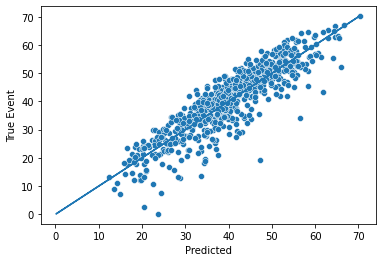

====> Train NLL: 17915.5971 	 Valid event loss: 35102.2898 	 censoring loss : 0.0000 	 Improved:  
epoch421
====> Train NLL: 17920.5201 	 Valid event loss: 35071.5898 	 censoring loss : 0.0000 	 Improved:  
epoch422
====> Train NLL: 17914.0654 	 Valid event loss: 35086.5726 	 censoring loss : 0.0000 	 Improved:  
epoch423
====> Train NLL: 17910.9611 	 Valid event loss: 35064.6143 	 censoring loss : 0.0000 	 Improved: *
epoch424
====> Train NLL: 17917.3647 	 Valid event loss: 35078.6696 	 censoring loss : 0.0000 	 Improved:  
epoch425
====> Train NLL: 17911.0061 	 Valid event loss: 35076.5899 	 censoring loss : 0.0000 	 Improved:  
epoch426
====> Train NLL: 17909.0424 	 Valid event loss: 35066.5954 	 censoring loss : 0.0000 	 Improved:  
epoch427
====> Train NLL: 17905.3284 	 Valid event loss: 35076.2513 	 censoring loss : 0.0000 	 Improved:  
epoch428
====> Train NLL: 17903.0818 	 Valid event loss: 35086.1054 	 censoring loss : 0.0000 	 Improved:  
epoch429
====> Train NLL: 17899.8579 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


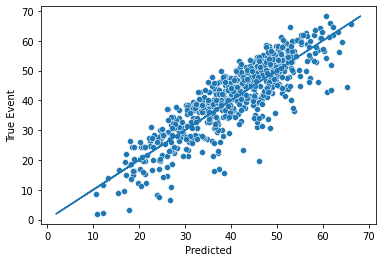

====> Train NLL: 17898.9989 	 Valid event loss: 35055.5827 	 censoring loss : 0.0000 	 Improved: *
epoch431
====> Train NLL: 17900.7092 	 Valid event loss: 35100.4760 	 censoring loss : 0.0000 	 Improved:  
epoch432
====> Train NLL: 17897.0080 	 Valid event loss: 35076.2430 	 censoring loss : 0.0000 	 Improved:  
epoch433
====> Train NLL: 17891.0478 	 Valid event loss: 35055.2097 	 censoring loss : 0.0000 	 Improved: *
epoch434
====> Train NLL: 17899.4789 	 Valid event loss: 35057.4379 	 censoring loss : 0.0000 	 Improved:  
epoch435
====> Train NLL: 17889.1252 	 Valid event loss: 35089.1086 	 censoring loss : 0.0000 	 Improved:  
epoch436
====> Train NLL: 17886.7406 	 Valid event loss: 35052.5605 	 censoring loss : 0.0000 	 Improved: *
epoch437
====> Train NLL: 17885.2699 	 Valid event loss: 35070.9495 	 censoring loss : 0.0000 	 Improved:  
epoch438
====> Train NLL: 17885.1252 	 Valid event loss: 35057.6908 	 censoring loss : 0.0000 	 Improved:  
epoch439
====> Train NLL: 17878.9329 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


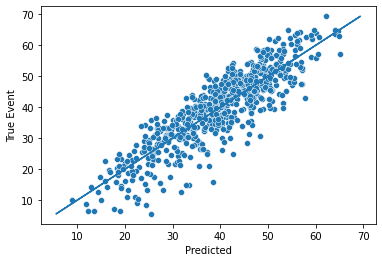

====> Train NLL: 17874.1429 	 Valid event loss: 35077.0939 	 censoring loss : 0.0000 	 Improved:  
epoch441
====> Train NLL: 17875.9545 	 Valid event loss: 35048.1914 	 censoring loss : 0.0000 	 Improved:  
epoch442
====> Train NLL: 17876.5336 	 Valid event loss: 35058.0066 	 censoring loss : 0.0000 	 Improved:  
epoch443
====> Train NLL: 17873.1292 	 Valid event loss: 35052.4774 	 censoring loss : 0.0000 	 Improved:  
epoch444
====> Train NLL: 17869.4887 	 Valid event loss: 35049.4239 	 censoring loss : 0.0000 	 Improved:  
epoch445
====> Train NLL: 17872.0217 	 Valid event loss: 35044.0549 	 censoring loss : 0.0000 	 Improved: *
epoch446
====> Train NLL: 17865.7834 	 Valid event loss: 35078.9535 	 censoring loss : 0.0000 	 Improved:  
epoch447
====> Train NLL: 17867.0909 	 Valid event loss: 35031.4737 	 censoring loss : 0.0000 	 Improved: *
epoch448
====> Train NLL: 17862.0941 	 Valid event loss: 35055.3033 	 censoring loss : 0.0000 	 Improved:  
epoch449
====> Train NLL: 17860.6135 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


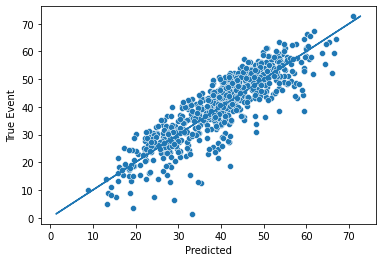

====> Train NLL: 17860.1980 	 Valid event loss: 35038.3108 	 censoring loss : 0.0000 	 Improved:  
epoch451
====> Train NLL: 17858.0685 	 Valid event loss: 35057.1383 	 censoring loss : 0.0000 	 Improved:  
epoch452
====> Train NLL: 17859.9326 	 Valid event loss: 35033.8894 	 censoring loss : 0.0000 	 Improved:  
epoch453
====> Train NLL: 17851.8849 	 Valid event loss: 35042.8686 	 censoring loss : 0.0000 	 Improved:  
epoch454
====> Train NLL: 17851.3815 	 Valid event loss: 35053.5137 	 censoring loss : 0.0000 	 Improved:  
epoch455
====> Train NLL: 17847.9274 	 Valid event loss: 35034.3460 	 censoring loss : 0.0000 	 Improved:  
epoch456
====> Train NLL: 17846.6077 	 Valid event loss: 35050.6453 	 censoring loss : 0.0000 	 Improved:  
epoch457
====> Train NLL: 17846.8121 	 Valid event loss: 35039.2747 	 censoring loss : 0.0000 	 Improved:  
epoch458
====> Train NLL: 17844.1419 	 Valid event loss: 35018.3719 	 censoring loss : 0.0000 	 Improved: *
epoch459
====> Train NLL: 17843.6779 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


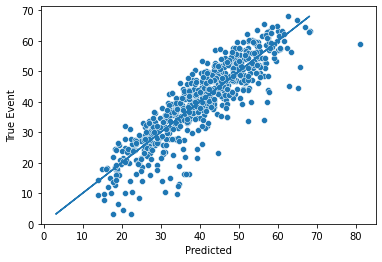

====> Train NLL: 17840.4601 	 Valid event loss: 35029.7359 	 censoring loss : 0.0000 	 Improved:  
epoch461
====> Train NLL: 17837.8592 	 Valid event loss: 35020.7585 	 censoring loss : 0.0000 	 Improved:  
epoch462
====> Train NLL: 17836.1364 	 Valid event loss: 35067.3009 	 censoring loss : 0.0000 	 Improved:  
epoch463
====> Train NLL: 17837.5061 	 Valid event loss: 35017.0545 	 censoring loss : 0.0000 	 Improved: *
epoch464
====> Train NLL: 17834.7960 	 Valid event loss: 35028.7829 	 censoring loss : 0.0000 	 Improved:  
epoch465
====> Train NLL: 17830.6204 	 Valid event loss: 35018.3654 	 censoring loss : 0.0000 	 Improved:  
epoch466
====> Train NLL: 17830.7002 	 Valid event loss: 35020.9313 	 censoring loss : 0.0000 	 Improved:  
epoch467
====> Train NLL: 17826.3997 	 Valid event loss: 35016.4997 	 censoring loss : 0.0000 	 Improved: *
epoch468
====> Train NLL: 17824.8051 	 Valid event loss: 35015.9069 	 censoring loss : 0.0000 	 Improved: *
epoch469
====> Train NLL: 17827.3157 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


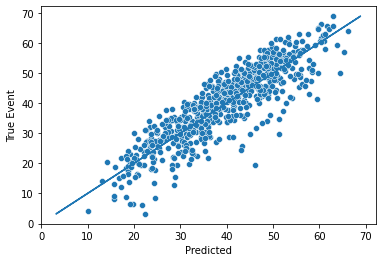

====> Train NLL: 17819.4555 	 Valid event loss: 35028.2538 	 censoring loss : 0.0000 	 Improved:  
epoch471
====> Train NLL: 17818.9042 	 Valid event loss: 35011.0418 	 censoring loss : 0.0000 	 Improved: *
epoch472
====> Train NLL: 17820.4293 	 Valid event loss: 35013.4819 	 censoring loss : 0.0000 	 Improved:  
epoch473
====> Train NLL: 17815.6834 	 Valid event loss: 35024.6388 	 censoring loss : 0.0000 	 Improved:  
epoch474
====> Train NLL: 17814.3437 	 Valid event loss: 35019.8585 	 censoring loss : 0.0000 	 Improved:  
epoch475
====> Train NLL: 17815.8264 	 Valid event loss: 35019.6205 	 censoring loss : 0.0000 	 Improved:  
epoch476
====> Train NLL: 17809.0045 	 Valid event loss: 35026.7960 	 censoring loss : 0.0000 	 Improved:  
epoch477
====> Train NLL: 17809.3321 	 Valid event loss: 35010.2184 	 censoring loss : 0.0000 	 Improved: *
epoch478
====> Train NLL: 17808.2980 	 Valid event loss: 35017.4180 	 censoring loss : 0.0000 	 Improved:  
epoch479
====> Train NLL: 17804.4789 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


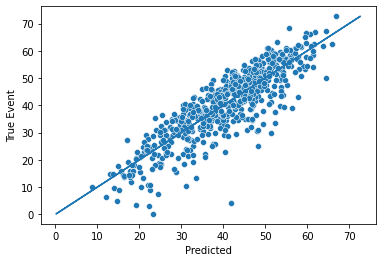

====> Train NLL: 17804.1619 	 Valid event loss: 35017.8917 	 censoring loss : 0.0000 	 Improved:  
epoch481
====> Train NLL: 17801.5906 	 Valid event loss: 35012.5167 	 censoring loss : 0.0000 	 Improved:  
epoch482
====> Train NLL: 17800.1585 	 Valid event loss: 34994.3971 	 censoring loss : 0.0000 	 Improved: *
epoch483
====> Train NLL: 17799.6197 	 Valid event loss: 35011.7529 	 censoring loss : 0.0000 	 Improved:  
epoch484
====> Train NLL: 17795.7853 	 Valid event loss: 35014.4569 	 censoring loss : 0.0000 	 Improved:  
epoch485
====> Train NLL: 17794.6000 	 Valid event loss: 35003.9076 	 censoring loss : 0.0000 	 Improved:  
epoch486
====> Train NLL: 17793.2344 	 Valid event loss: 35000.5838 	 censoring loss : 0.0000 	 Improved:  
epoch487
====> Train NLL: 17790.4054 	 Valid event loss: 35009.2477 	 censoring loss : 0.0000 	 Improved:  
epoch488
====> Train NLL: 17786.7511 	 Valid event loss: 34999.4109 	 censoring loss : 0.0000 	 Improved:  
epoch489
====> Train NLL: 17785.9285 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


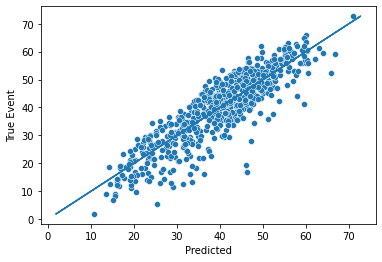

====> Train NLL: 17784.4108 	 Valid event loss: 34999.9158 	 censoring loss : 0.0000 	 Improved:  
epoch491
====> Train NLL: 17783.5944 	 Valid event loss: 35011.4599 	 censoring loss : 0.0000 	 Improved:  
epoch492
====> Train NLL: 17780.8779 	 Valid event loss: 34990.4486 	 censoring loss : 0.0000 	 Improved: *
epoch493
====> Train NLL: 17779.9898 	 Valid event loss: 35002.7185 	 censoring loss : 0.0000 	 Improved:  
epoch494
====> Train NLL: 17782.3424 	 Valid event loss: 35024.8606 	 censoring loss : 0.0000 	 Improved:  
epoch495
====> Train NLL: 17775.9271 	 Valid event loss: 34987.9698 	 censoring loss : 0.0000 	 Improved: *
epoch496
====> Train NLL: 17775.9187 	 Valid event loss: 34993.9004 	 censoring loss : 0.0000 	 Improved:  
epoch497
====> Train NLL: 17771.8774 	 Valid event loss: 34990.5084 	 censoring loss : 0.0000 	 Improved:  
epoch498
====> Train NLL: 17772.5702 	 Valid event loss: 35005.7207 	 censoring loss : 0.0000 	 Improved:  
epoch499
====> Train NLL: 17772.5139 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


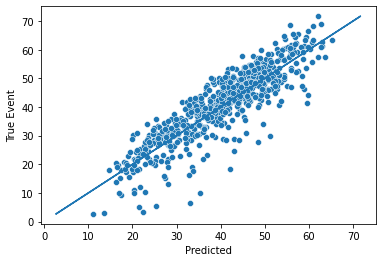

====> Train NLL: 17769.7768 	 Valid event loss: 35000.4904 	 censoring loss : 0.0000 	 Improved:  
epoch501
====> Train NLL: 17764.6561 	 Valid event loss: 34988.6495 	 censoring loss : 0.0000 	 Improved:  
epoch502
====> Train NLL: 17764.7016 	 Valid event loss: 34984.3488 	 censoring loss : 0.0000 	 Improved:  
epoch503
====> Train NLL: 17767.4523 	 Valid event loss: 34999.3587 	 censoring loss : 0.0000 	 Improved:  
epoch504
====> Train NLL: 17763.7017 	 Valid event loss: 34975.7411 	 censoring loss : 0.0000 	 Improved: *
epoch505
====> Train NLL: 17761.3143 	 Valid event loss: 35005.8166 	 censoring loss : 0.0000 	 Improved:  
epoch506
====> Train NLL: 17758.5942 	 Valid event loss: 34991.5860 	 censoring loss : 0.0000 	 Improved:  
epoch507
====> Train NLL: 17756.9537 	 Valid event loss: 35002.1761 	 censoring loss : 0.0000 	 Improved:  
epoch508
====> Train NLL: 17756.5225 	 Valid event loss: 34986.3825 	 censoring loss : 0.0000 	 Improved:  
epoch509
====> Train NLL: 17755.8802 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


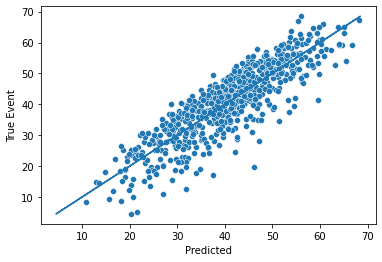

====> Train NLL: 17750.7712 	 Valid event loss: 34971.6870 	 censoring loss : 0.0000 	 Improved: *
epoch511
====> Train NLL: 17752.4119 	 Valid event loss: 34981.9756 	 censoring loss : 0.0000 	 Improved:  
epoch512
====> Train NLL: 17750.6387 	 Valid event loss: 34986.9591 	 censoring loss : 0.0000 	 Improved:  
epoch513
====> Train NLL: 17746.3388 	 Valid event loss: 34984.5280 	 censoring loss : 0.0000 	 Improved:  
epoch514
====> Train NLL: 17745.7478 	 Valid event loss: 34979.1742 	 censoring loss : 0.0000 	 Improved:  
epoch515
====> Train NLL: 17742.9306 	 Valid event loss: 35000.8911 	 censoring loss : 0.0000 	 Improved:  
epoch516
====> Train NLL: 17743.1016 	 Valid event loss: 35000.2473 	 censoring loss : 0.0000 	 Improved:  
epoch517
====> Train NLL: 17740.5423 	 Valid event loss: 34994.5102 	 censoring loss : 0.0000 	 Improved:  
epoch518
====> Train NLL: 17742.1083 	 Valid event loss: 34998.2625 	 censoring loss : 0.0000 	 Improved:  
epoch519
====> Train NLL: 17737.6893 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


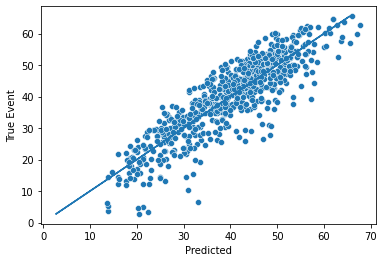

====> Train NLL: 17736.9237 	 Valid event loss: 34989.8286 	 censoring loss : 0.0000 	 Improved:  
epoch521
====> Train NLL: 17734.7676 	 Valid event loss: 34968.7691 	 censoring loss : 0.0000 	 Improved: *
epoch522
====> Train NLL: 17731.5688 	 Valid event loss: 34975.4094 	 censoring loss : 0.0000 	 Improved:  
epoch523
====> Train NLL: 17730.3124 	 Valid event loss: 34986.3610 	 censoring loss : 0.0000 	 Improved:  
epoch524
====> Train NLL: 17729.6725 	 Valid event loss: 34969.2191 	 censoring loss : 0.0000 	 Improved:  
epoch525
====> Train NLL: 17726.6502 	 Valid event loss: 34990.6272 	 censoring loss : 0.0000 	 Improved:  
epoch526
====> Train NLL: 17729.5356 	 Valid event loss: 34972.2363 	 censoring loss : 0.0000 	 Improved:  
epoch527
====> Train NLL: 17724.6053 	 Valid event loss: 34980.1131 	 censoring loss : 0.0000 	 Improved:  
epoch528
====> Train NLL: 17727.5656 	 Valid event loss: 34978.5548 	 censoring loss : 0.0000 	 Improved:  
epoch529
====> Train NLL: 17722.7459 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


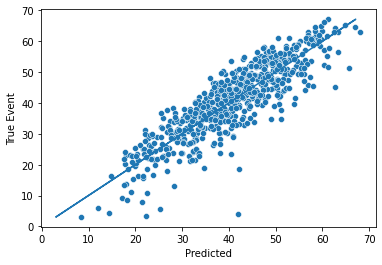

====> Train NLL: 17719.2447 	 Valid event loss: 34987.2892 	 censoring loss : 0.0000 	 Improved:  
epoch531
====> Train NLL: 17717.9129 	 Valid event loss: 34964.1590 	 censoring loss : 0.0000 	 Improved:  
epoch532
====> Train NLL: 17717.1004 	 Valid event loss: 34969.6895 	 censoring loss : 0.0000 	 Improved:  
epoch533
====> Train NLL: 17716.2703 	 Valid event loss: 34974.1338 	 censoring loss : 0.0000 	 Improved:  
epoch534
====> Train NLL: 17713.8174 	 Valid event loss: 34960.1461 	 censoring loss : 0.0000 	 Improved: *
epoch535
====> Train NLL: 17715.2677 	 Valid event loss: 34961.4501 	 censoring loss : 0.0000 	 Improved:  
epoch536
====> Train NLL: 17711.7872 	 Valid event loss: 34956.7485 	 censoring loss : 0.0000 	 Improved: *
epoch537
====> Train NLL: 17715.7757 	 Valid event loss: 34957.2967 	 censoring loss : 0.0000 	 Improved:  
epoch538
====> Train NLL: 17707.3426 	 Valid event loss: 34971.1484 	 censoring loss : 0.0000 	 Improved:  
epoch539
====> Train NLL: 17707.9214 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


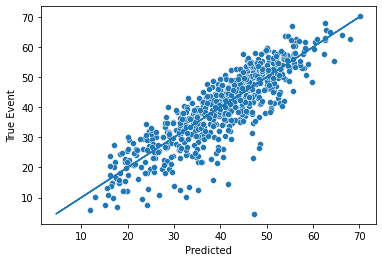

====> Train NLL: 17707.6204 	 Valid event loss: 34958.4458 	 censoring loss : 0.0000 	 Improved:  
epoch541
====> Train NLL: 17703.4881 	 Valid event loss: 34961.3400 	 censoring loss : 0.0000 	 Improved:  
epoch542
====> Train NLL: 17701.2089 	 Valid event loss: 34954.3204 	 censoring loss : 0.0000 	 Improved: *
epoch543
====> Train NLL: 17703.0060 	 Valid event loss: 34955.2140 	 censoring loss : 0.0000 	 Improved:  
epoch544
====> Train NLL: 17700.1651 	 Valid event loss: 34975.2719 	 censoring loss : 0.0000 	 Improved:  
epoch545
====> Train NLL: 17703.1954 	 Valid event loss: 34954.9917 	 censoring loss : 0.0000 	 Improved:  
epoch546
====> Train NLL: 17699.0008 	 Valid event loss: 34971.5614 	 censoring loss : 0.0000 	 Improved:  
epoch547
====> Train NLL: 17696.3176 	 Valid event loss: 34955.8550 	 censoring loss : 0.0000 	 Improved:  
epoch548
====> Train NLL: 17694.4541 	 Valid event loss: 34970.5110 	 censoring loss : 0.0000 	 Improved:  
epoch549
====> Train NLL: 17691.5021 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


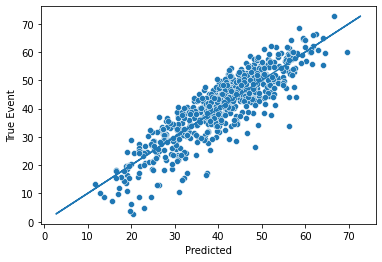

====> Train NLL: 17689.1633 	 Valid event loss: 34962.6037 	 censoring loss : 0.0000 	 Improved:  
epoch551
====> Train NLL: 17696.3327 	 Valid event loss: 34943.1882 	 censoring loss : 0.0000 	 Improved: *
epoch552
====> Train NLL: 17686.6045 	 Valid event loss: 34967.3414 	 censoring loss : 0.0000 	 Improved:  
epoch553
====> Train NLL: 17686.3041 	 Valid event loss: 34946.3930 	 censoring loss : 0.0000 	 Improved:  
epoch554
====> Train NLL: 17685.8411 	 Valid event loss: 34968.2120 	 censoring loss : 0.0000 	 Improved:  
epoch555
====> Train NLL: 17682.2416 	 Valid event loss: 34942.3826 	 censoring loss : 0.0000 	 Improved: *
epoch556
====> Train NLL: 17686.3620 	 Valid event loss: 34952.4663 	 censoring loss : 0.0000 	 Improved:  
epoch557
====> Train NLL: 17681.2262 	 Valid event loss: 34979.3511 	 censoring loss : 0.0000 	 Improved:  
epoch558
====> Train NLL: 17676.5045 	 Valid event loss: 34945.1184 	 censoring loss : 0.0000 	 Improved:  
epoch559
====> Train NLL: 17676.0941 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


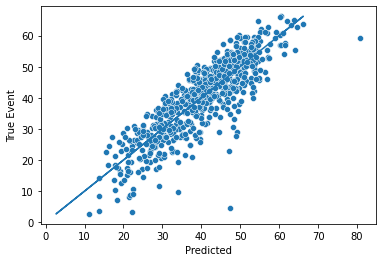

====> Train NLL: 17675.3311 	 Valid event loss: 34947.8581 	 censoring loss : 0.0000 	 Improved:  
epoch561
====> Train NLL: 17673.1937 	 Valid event loss: 34946.9815 	 censoring loss : 0.0000 	 Improved:  
epoch562
====> Train NLL: 17673.4779 	 Valid event loss: 34958.9860 	 censoring loss : 0.0000 	 Improved:  
epoch563
====> Train NLL: 17672.2496 	 Valid event loss: 34956.7859 	 censoring loss : 0.0000 	 Improved:  
epoch564
====> Train NLL: 17671.4478 	 Valid event loss: 34952.8113 	 censoring loss : 0.0000 	 Improved:  
epoch565
====> Train NLL: 17669.7548 	 Valid event loss: 34961.0924 	 censoring loss : 0.0000 	 Improved:  
epoch566
====> Train NLL: 17673.8650 	 Valid event loss: 34945.2196 	 censoring loss : 0.0000 	 Improved:  
epoch567
====> Train NLL: 17670.9377 	 Valid event loss: 34939.0290 	 censoring loss : 0.0000 	 Improved: *
epoch568
====> Train NLL: 17667.1123 	 Valid event loss: 34967.6440 	 censoring loss : 0.0000 	 Improved:  
epoch569
====> Train NLL: 17666.0824 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


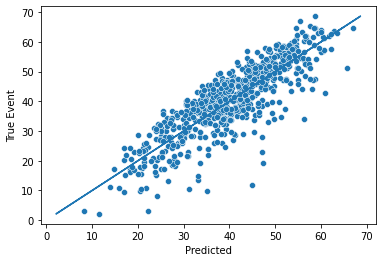

====> Train NLL: 17659.5973 	 Valid event loss: 34948.7261 	 censoring loss : 0.0000 	 Improved:  
epoch571
====> Train NLL: 17665.5403 	 Valid event loss: 34959.3588 	 censoring loss : 0.0000 	 Improved:  
epoch572
====> Train NLL: 17659.1380 	 Valid event loss: 34957.3233 	 censoring loss : 0.0000 	 Improved:  
epoch573
====> Train NLL: 17657.3497 	 Valid event loss: 34965.4847 	 censoring loss : 0.0000 	 Improved:  
epoch574
====> Train NLL: 17655.9395 	 Valid event loss: 34963.1806 	 censoring loss : 0.0000 	 Improved:  
epoch575
====> Train NLL: 17656.7419 	 Valid event loss: 34946.8457 	 censoring loss : 0.0000 	 Improved:  
epoch576
====> Train NLL: 17655.1291 	 Valid event loss: 34937.5166 	 censoring loss : 0.0000 	 Improved: *
epoch577
====> Train NLL: 17653.8217 	 Valid event loss: 34950.4213 	 censoring loss : 0.0000 	 Improved:  
epoch578
====> Train NLL: 17649.9747 	 Valid event loss: 34941.6964 	 censoring loss : 0.0000 	 Improved:  
epoch579
====> Train NLL: 17656.7755 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


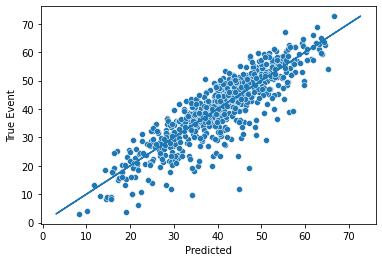

====> Train NLL: 17646.3365 	 Valid event loss: 34941.0120 	 censoring loss : 0.0000 	 Improved:  
epoch581
====> Train NLL: 17645.5280 	 Valid event loss: 34940.1547 	 censoring loss : 0.0000 	 Improved:  
epoch582
====> Train NLL: 17643.2460 	 Valid event loss: 34949.4175 	 censoring loss : 0.0000 	 Improved:  
epoch583
====> Train NLL: 17641.9351 	 Valid event loss: 34941.0677 	 censoring loss : 0.0000 	 Improved:  
epoch584
====> Train NLL: 17640.5188 	 Valid event loss: 34941.2372 	 censoring loss : 0.0000 	 Improved:  
epoch585
====> Train NLL: 17641.1776 	 Valid event loss: 34938.4703 	 censoring loss : 0.0000 	 Improved:  
epoch586
====> Train NLL: 17639.4241 	 Valid event loss: 34946.6045 	 censoring loss : 0.0000 	 Improved:  
epoch587
====> Train NLL: 17636.4154 	 Valid event loss: 34940.0260 	 censoring loss : 0.0000 	 Improved:  
epoch588
====> Train NLL: 17635.6125 	 Valid event loss: 34949.4454 	 censoring loss : 0.0000 	 Improved:  
epoch589
====> Train NLL: 17635.8971 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


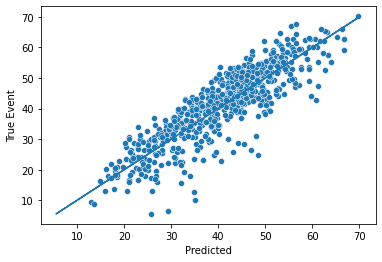

====> Train NLL: 17635.0931 	 Valid event loss: 34950.1921 	 censoring loss : 0.0000 	 Improved:  
epoch591
====> Train NLL: 17635.7286 	 Valid event loss: 34955.6059 	 censoring loss : 0.0000 	 Improved:  
epoch592
====> Train NLL: 17636.5929 	 Valid event loss: 34942.7263 	 censoring loss : 0.0000 	 Improved:  
epoch593
====> Train NLL: 17629.5694 	 Valid event loss: 34940.3966 	 censoring loss : 0.0000 	 Improved:  
epoch594
====> Train NLL: 17628.3580 	 Valid event loss: 34939.3752 	 censoring loss : 0.0000 	 Improved:  
epoch595
====> Train NLL: 17626.5508 	 Valid event loss: 34930.1803 	 censoring loss : 0.0000 	 Improved: *
epoch596
====> Train NLL: 17624.2480 	 Valid event loss: 34950.5766 	 censoring loss : 0.0000 	 Improved:  
epoch597
====> Train NLL: 17625.9775 	 Valid event loss: 34925.0004 	 censoring loss : 0.0000 	 Improved: *
epoch598
====> Train NLL: 17622.4689 	 Valid event loss: 34926.8438 	 censoring loss : 0.0000 	 Improved:  
epoch599
====> Train NLL: 17622.7963 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


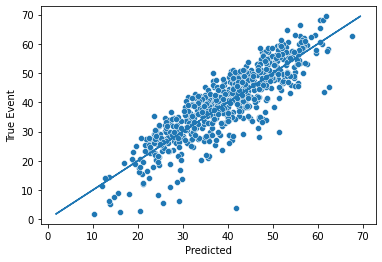

====> Train NLL: 17619.3130 	 Valid event loss: 34952.1066 	 censoring loss : 0.0000 	 Improved:  
epoch601
====> Train NLL: 17617.3851 	 Valid event loss: 34936.2846 	 censoring loss : 0.0000 	 Improved:  
epoch602
====> Train NLL: 17616.4705 	 Valid event loss: 34934.5756 	 censoring loss : 0.0000 	 Improved:  
epoch603
====> Train NLL: 17614.3313 	 Valid event loss: 34943.3967 	 censoring loss : 0.0000 	 Improved:  
epoch604
====> Train NLL: 17614.0865 	 Valid event loss: 34926.3770 	 censoring loss : 0.0000 	 Improved:  
epoch605
====> Train NLL: 17612.0635 	 Valid event loss: 34936.6067 	 censoring loss : 0.0000 	 Improved:  
epoch606
====> Train NLL: 17617.3974 	 Valid event loss: 34929.0158 	 censoring loss : 0.0000 	 Improved:  
epoch607
====> Train NLL: 17611.2734 	 Valid event loss: 34927.5310 	 censoring loss : 0.0000 	 Improved:  
epoch608
====> Train NLL: 17607.5827 	 Valid event loss: 34928.0811 	 censoring loss : 0.0000 	 Improved:  
epoch609
====> Train NLL: 17612.1131 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


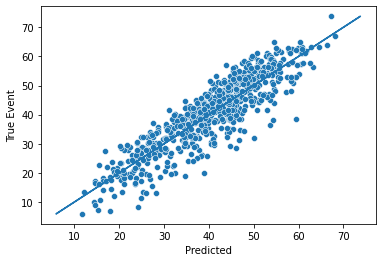

====> Train NLL: 17612.9824 	 Valid event loss: 34927.4563 	 censoring loss : 0.0000 	 Improved:  
epoch611
====> Train NLL: 17605.9806 	 Valid event loss: 34933.2837 	 censoring loss : 0.0000 	 Improved:  
epoch612
====> Train NLL: 17602.9530 	 Valid event loss: 34937.5053 	 censoring loss : 0.0000 	 Improved:  
epoch613
====> Train NLL: 17603.1274 	 Valid event loss: 34925.1777 	 censoring loss : 0.0000 	 Improved:  
epoch614
====> Train NLL: 17607.6229 	 Valid event loss: 34932.3778 	 censoring loss : 0.0000 	 Improved:  
epoch615
====> Train NLL: 17597.1993 	 Valid event loss: 34919.8323 	 censoring loss : 0.0000 	 Improved: *
epoch616
====> Train NLL: 17603.2327 	 Valid event loss: 34921.5303 	 censoring loss : 0.0000 	 Improved:  
epoch617
====> Train NLL: 17597.3448 	 Valid event loss: 34945.8537 	 censoring loss : 0.0000 	 Improved:  
epoch618
====> Train NLL: 17595.8953 	 Valid event loss: 34915.7694 	 censoring loss : 0.0000 	 Improved: *
epoch619
====> Train NLL: 17593.5239 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


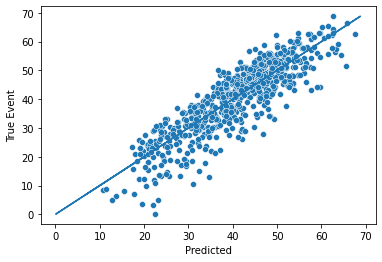

====> Train NLL: 17591.5355 	 Valid event loss: 34951.4731 	 censoring loss : 0.0000 	 Improved:  
epoch621
====> Train NLL: 17592.7980 	 Valid event loss: 34959.4498 	 censoring loss : 0.0000 	 Improved:  
epoch622
====> Train NLL: 17593.6368 	 Valid event loss: 34924.2670 	 censoring loss : 0.0000 	 Improved:  
epoch623
====> Train NLL: 17590.4532 	 Valid event loss: 34929.1202 	 censoring loss : 0.0000 	 Improved:  
epoch624
====> Train NLL: 17598.2313 	 Valid event loss: 34930.7225 	 censoring loss : 0.0000 	 Improved:  
epoch625
====> Train NLL: 17590.6177 	 Valid event loss: 34920.5021 	 censoring loss : 0.0000 	 Improved:  
epoch626
====> Train NLL: 17584.0193 	 Valid event loss: 34933.9950 	 censoring loss : 0.0000 	 Improved:  
epoch627
====> Train NLL: 17583.8174 	 Valid event loss: 34931.6167 	 censoring loss : 0.0000 	 Improved:  
epoch628
====> Train NLL: 17585.0750 	 Valid event loss: 34942.2065 	 censoring loss : 0.0000 	 Improved:  
epoch629
====> Train NLL: 17584.6121 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


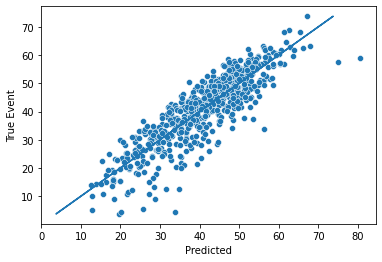

====> Train NLL: 17582.3243 	 Valid event loss: 34923.8522 	 censoring loss : 0.0000 	 Improved:  
epoch631
====> Train NLL: 17578.0359 	 Valid event loss: 34934.1229 	 censoring loss : 0.0000 	 Improved:  
epoch632
====> Train NLL: 17579.8922 	 Valid event loss: 34946.4377 	 censoring loss : 0.0000 	 Improved:  
epoch633
====> Train NLL: 17574.1968 	 Valid event loss: 34908.8703 	 censoring loss : 0.0000 	 Improved: *
epoch634
====> Train NLL: 17580.1063 	 Valid event loss: 34915.9847 	 censoring loss : 0.0000 	 Improved:  
epoch635
====> Train NLL: 17575.2553 	 Valid event loss: 34919.0352 	 censoring loss : 0.0000 	 Improved:  
epoch636
====> Train NLL: 17573.1379 	 Valid event loss: 34925.5768 	 censoring loss : 0.0000 	 Improved:  
epoch637
====> Train NLL: 17572.3877 	 Valid event loss: 34927.2843 	 censoring loss : 0.0000 	 Improved:  
epoch638
====> Train NLL: 17570.6744 	 Valid event loss: 34925.3005 	 censoring loss : 0.0000 	 Improved:  
epoch639
====> Train NLL: 17572.1732 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


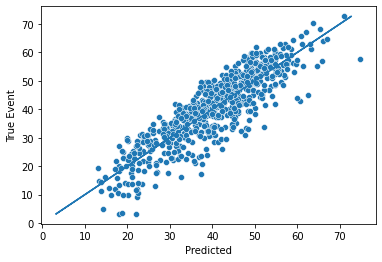

====> Train NLL: 17572.2738 	 Valid event loss: 34931.0026 	 censoring loss : 0.0000 	 Improved:  
epoch641
====> Train NLL: 17569.3547 	 Valid event loss: 34916.9311 	 censoring loss : 0.0000 	 Improved:  
epoch642
====> Train NLL: 17565.0691 	 Valid event loss: 34925.1415 	 censoring loss : 0.0000 	 Improved:  
epoch643
====> Train NLL: 17563.2835 	 Valid event loss: 34919.3263 	 censoring loss : 0.0000 	 Improved:  
epoch644
====> Train NLL: 17566.3461 	 Valid event loss: 34914.3979 	 censoring loss : 0.0000 	 Improved:  
epoch645
====> Train NLL: 17565.0634 	 Valid event loss: 34930.5331 	 censoring loss : 0.0000 	 Improved:  
epoch646
====> Train NLL: 17560.7472 	 Valid event loss: 34914.0964 	 censoring loss : 0.0000 	 Improved:  
epoch647
====> Train NLL: 17560.6938 	 Valid event loss: 34927.0717 	 censoring loss : 0.0000 	 Improved:  
epoch648
====> Train NLL: 17557.4454 	 Valid event loss: 34912.4244 	 censoring loss : 0.0000 	 Improved:  
epoch649
====> Train NLL: 17556.2022 

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


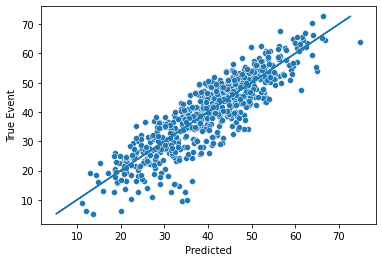

====> Train NLL: 17558.6770 	 Valid event loss: 34919.3376 	 censoring loss : 0.0000 	 Improved:  
epoch651
====> Train NLL: 17553.5805 	 Valid event loss: 34926.1913 	 censoring loss : 0.0000 	 Improved:  
epoch652
====> Train NLL: 17556.0631 	 Valid event loss: 34916.3330 	 censoring loss : 0.0000 	 Improved:  
epoch653
====> Train NLL: 17552.7132 	 Valid event loss: 34918.2618 	 censoring loss : 0.0000 	 Improved:  
Model stopped due to early stopping


In [16]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_e_loss = 0
    valid_c_loss = 0
    print('epoch'+str(epoch))
    improved_str = " "
    encoder.train()
    decoder.train()
    for i, (x, y, e) in enumerate(pair1):
        
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        z = encoder(x)
        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat-y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
        loss = closs + eloss
    
        
#         y_loglikeli = -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-4).log().mean()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1e-3)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-3)

        train_loss += loss.item()
        
        opt_enc.step()  
        opt_dec.step()  
        
    train_loss = train_loss/(i+1)     

    
    encoder.eval()
    decoder.eval()
    valid_loss = 0
    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)        
        z = encoder(x)
        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()

        valid_e_loss += eloss.item()
        
        valid_c_loss += closs.item()



    valid_e_loss = valid_e_loss/(i+1)
    valid_c_loss = valid_c_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_e_loss)
    
    save_model = 0
    if (best_valid_loss > valid_e_loss):
        save_model += 1
        
    if epoch % 10 == 0:
        subj = np.random.choice(len(e))
        plt.figure()
        
        sns.scatterplot(t_hat[e==1].cpu().detach().numpy().squeeze(), y[e==1].cpu())
        plt.plot(y[e==1].cpu(), y[e==1].cpu())
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
#         plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

# #         sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
#         true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
#         sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
#         plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.
#         plt.title(r'$\delta$='+str(e[subj].item()))

        plt.show()
    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_e_loss
        torch.save(encoder.state_dict(), enc_path)
        torch.save(decoder.state_dict(), dec_path)

        improved_str = "*"
    print('====> Train NLL: {:.4f} \t Valid event loss: {:.4f} \t censoring loss : {:.4f} \t Improved: {}'.format(train_loss, valid_e_loss, valid_c_loss,improved_str))

    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

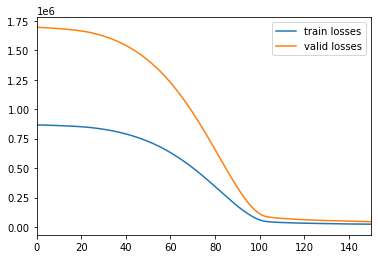

In [17]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.xlim(0,150)
plt.legend()


In [18]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

encoder.eval()
decoder.eval()
valid_e_loss = valid_c_loss= 0
valid_pred_t = []
valid_t = []
valid_e = []
for i, (x, y, e) in enumerate(v_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)        
    z = encoder(x)
    t_hat = decoder(z)
    hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
    closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
    eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()

    valid_e_loss += eloss.item()

    valid_c_loss += closs.item()
    
    valid_pred_t.append(t_hat.squeeze())
    valid_t.append(y.squeeze())
    valid_e.append(e.squeeze())

print(valid_e_loss)


244362.0924142358


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'True Event')

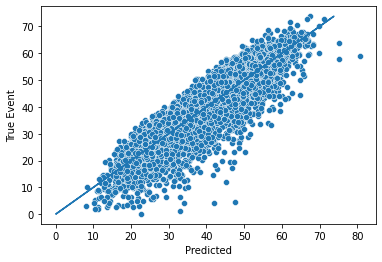

In [19]:
valid_e = torch.cat(valid_e)
valid_t = torch.cat(valid_t)
valid_pred_t = torch.cat(valid_pred_t)


subj = np.random.choice(len(valid_e))
plt.figure()

sns.scatterplot(valid_pred_t[valid_e==1].cpu().detach().numpy().squeeze(), valid_t[valid_e==1].cpu())
plt.plot(valid_t[valid_e==1].cpu(), valid_t[valid_e==1].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')


In [28]:
# single head attention
# https://github.com/QiangAIResearcher/sahp_repo/blob/master/models/attention/single.py

import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import numpy as np

class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """
    def forward(self, query, key, value, mask=None, dropout=None):

        # scores = torch.matmul(query, key.transpose(-2, -1)) \
        #          / math.sqrt(query.size(-1))
        
        # f(query, key)
        scores = torch.exp(torch.matmul(query, key.transpose(-2, -1))) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn
    
    
class MultiHeadedAttention(nn.Module):
    """
    Take in models size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model, bias=True) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model, bias=True)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # the same mask applies to all heads
            # unsqueeze Returns a new tensor with a dimension of size one
            # inserted at the specified position.
            mask = mask.unsqueeze(1)

        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention.forward(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

## define MLP network

In [52]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

class EncMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(EncMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        z = self.net(x)
        return z
    
class DecMLP_cts(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP_cts, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
#         self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        return z

    
class DecMLP_clf(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(DecMLP_clf, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)
    
    
class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(SimpleMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)

In [53]:
n=10000
X = train['x']
# beta_linear = np.array([0.15,0.001])
# FX = np.dot(X,beta_linear).reshape((n,1))
t = train['t']
ncov = X.shape[1]
covList = np.arange(ncov)
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

trainData = SimpleDataset(X, t, train['e'], transform=True, mean=mean, std = std)
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(test['x'], test['t'], test['e'], transform=True, mean=mean, std = std)
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

NameError: name 'train' is not defined

In [51]:
ncov = X.shape[1]
zdim = 2
epochs = 1000
device = 'cpu'
# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])

decoder = DecMLP_cts(input_size = zdim, output_size = 1, h_dim=[128,128])
# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)
enc_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'enc_only.pt'
dec_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'dec_only.pt'

print(encoder, decoder)

NameError: name 'X' is not defined

Text(0, 0.5, 'True Event')

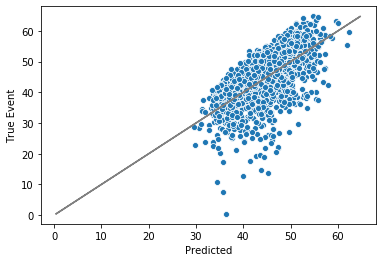

In [136]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

x = (torch.tensor(test['x']).to(device).float()-mean)/std
y = test['t']
e = test['e']
z = encoder(x.to(device).float())
t_hat = decoder(z)
sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
plt.plot(y[e==1], y[e==1], color='gray')

plt.xlabel('Predicted')
plt.ylabel('True Event')
# plt.xlim(min(t_hat.squeeze().detach()), max(y))
# plt.ylim(min(t_hat.squeeze().detach()), max(y))



Text(0, 0.5, 'True Event')

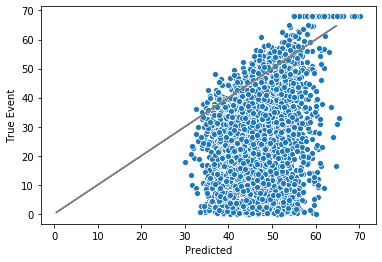

In [137]:
sns.scatterplot(t_hat[e==0].detach().numpy().squeeze(), y[e==0])
plt.plot(y[e==1], y[e==1], color='gray')

plt.xlabel('Predicted')
plt.ylabel('True Event')


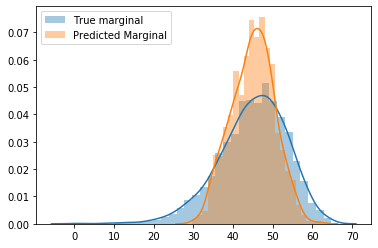

In [138]:
sns.distplot(y[e==1], label = 'True marginal')
sns.distplot(t_hat[e==1].detach().numpy(), label = 'Predicted Marginal')
plt.legend()

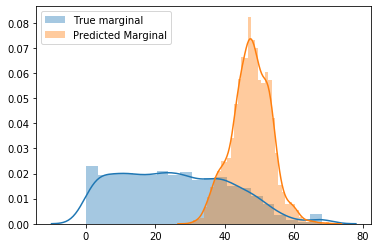

In [140]:
sns.distplot(y[e==0], label = 'True marginal')
sns.distplot(t_hat[e==0].detach().numpy(), label = 'Predicted Marginal')
plt.legend()

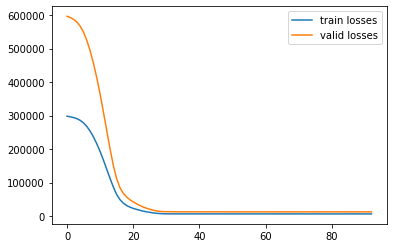

In [141]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [73]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

encoder.eval()
decoder.eval()
x = (torch.tensor(test['x']).to(device).float()-mean)/std
z = encoder(x.to(device).float())
t = decoder(z)

calculate_KS_Div((x[test['e']==1,:]*std)+mean, p_raw[test['e']==1,:], tt), calculate_KS_Div((x*std)+mean, p_raw, tt)


NameError: name 'calculate_KS_Div' is not defined

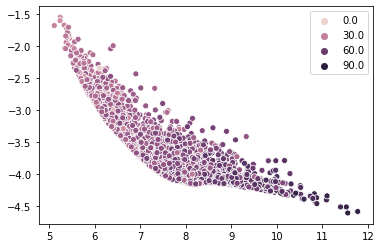

In [142]:
sns.scatterplot(z[:,0].detach(), z[:,1].detach(), hue=test['T'])

/Users/ZidiXiu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/ZidiXiu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


(tensor(55.4096), tensor(1))

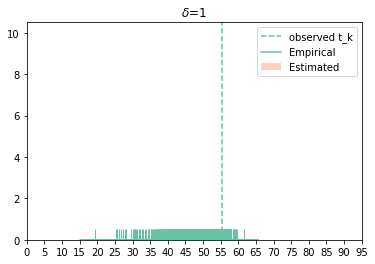

In [156]:
y = torch.tensor(test['t']).to(device).float()
e = torch.tensor(test['e']).to(device)
# y_cat = batch_t_categorize(y, e, tt)
x = (torch.tensor(test['x']).to(device).float()-mean)/std

subj = 6
x_new = x[subj,:].expand(100,-1)
z = encoder(x_new.to(device).float())
t_hat = decoder(z)


plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')
sns.distplot(t_hat.detach().numpy(), label='Estimated', color=pred_color)
# sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

plt.legend(loc='best')
plt.title(r'$\delta$='+str(e[subj].item()))
y[subj], e[subj]



## select pairs with data loader

In [159]:
for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
    # PAIR 1 need to be non-censored ? +(1-e1)
    # y1 should not equal to y2
    delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
#     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
    x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
    x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]
    
    batch_label = 1*(y1 > y2)
    batch_pair = torch.cat([x1, x2],axis = 1)
    break

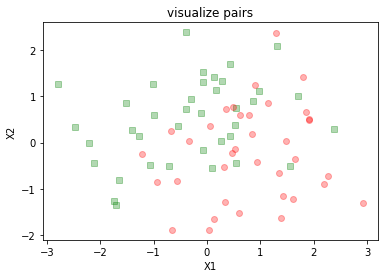

In [160]:
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)
_ = plt.title('visualize pairs')
_ = plt.plot(batch_pair[pos_idx,0].tolist(),batch_pair[pos_idx,ncov].tolist(),'sg',alpha=.3, label='T(X1)>T(X2)')
_ = plt.plot(batch_pair[neg_idx,0].tolist(),batch_pair[neg_idx,ncov].tolist(),'or',alpha=.3, label='T(X1)<T(X2)')

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

## Define the network

In [177]:
# if retrain encoder, decoder
ncov = X.shape[1]
zdim = 2
epochs = 1000
device = 'cpu'
# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])

decoder = DecMLP(input_size = zdim, output_size = 1, h_dim=[128,128])
# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)



hidden_layer=[128,128]
epochs = 1000
device = 'cpu'
# input is pair of X
clf = SimpleMLP(input_size = 2*zdim, output_size = 1, h_dim=hidden_layer)

# define optimizer
opt_clf = optim.Adam(clf.parameters(), lr=1e-4)

# define weight
ctr_wt = 1
clf_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'clf_'+str(ctr_wt)+'.pt'

enc_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'enc_'+str(ctr_wt)+'.pt'
dec_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'dec_'+str(ctr_wt)+'.pt'
print(encoder, decoder)
print(clf)


EncMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
) DecMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)
SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
  (out): Sigmoid()
)


In [178]:
def single_patient_true_surv_cox_gompertz(covariates, beta_linear = np.array([0.15,0.001]),lambda_=7e-8, alpha_=0.2138, n=1000,seed=123,tt=np.linspace(0,1,100)):
    
    X_age = covariates[0]
    X_randon = covariates[1]
    X_cts = [X_age, X_randon]     
    X = X_cts
    St = np.exp(-(lambda_/alpha_)*(np.exp(alpha_*tt)-1)*np.exp(np.dot(X,beta_linear)))
    return({"St": St})

# KS divergence
def KS_D(F1, F2, tt):
    diff_list = np.abs((np.ones(len(tt))-F1)-(np.ones(len(tt))-F2))
    return(tt[np.argmax(diff_list)], np.max(diff_list), diff_list)

def calculate_KS_Div(x, p_raw, tt):
    KS_list = []
    for subj in np.arange(p_raw.shape[0]):
        true_St=single_patient_true_surv_cox_gompertz(covariates=x[subj,:].numpy(), tt=tt)['St']
        St = 1-np.cumsum(p_raw[subj,:].detach().numpy())
        diff_t, diff_D, diff_list = KS_D(St, true_St, tt)
        KS_list.append(diff_D)

    return np.mean(KS_list)

epoch1
====> Train Loss: 598019.7891 	 NLL: 598019.0964 	 contrastive loss: 0.6927
====> Valid NLL loss: 597951.3697 	Improved: *
epoch2
====> Train Loss: 594047.0299 	 NLL: 594046.3373 	 contrastive loss: 0.6926
====> Valid NLL loss: 593967.2894 	Improved: *
epoch3
====> Train Loss: 589606.2762 	 NLL: 589605.5859 	 contrastive loss: 0.6904
====> Valid NLL loss: 588863.4839 	Improved: *
epoch4
====> Train Loss: 583396.0191 	 NLL: 583395.3324 	 contrastive loss: 0.6866
====> Valid NLL loss: 581354.4926 	Improved: *
epoch5
====> Train Loss: 574136.1998 	 NLL: 574135.5143 	 contrastive loss: 0.6854
====> Valid NLL loss: 570171.2735 	Improved: *
epoch6
====> Train Loss: 560883.1960 	 NLL: 560882.5164 	 contrastive loss: 0.6796
====> Valid NLL loss: 554962.1832 	Improved: *
epoch7
====> Train Loss: 543442.8007 	 NLL: 543442.1210 	 contrastive loss: 0.6797
====> Valid NLL loss: 535245.0540 	Improved: *
epoch8
====> Train Loss: 521175.5906 	 NLL: 521174.9125 	 contrastive loss: 0.6781
====> V

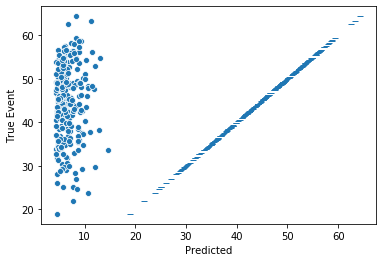

====> Valid NLL loss: 443585.2255 	Improved: *
epoch11
====> Train Loss: 420164.6468 	 NLL: 420163.9572 	 contrastive loss: 0.6896
====> Valid NLL loss: 401766.9092 	Improved: *
epoch12
====> Train Loss: 374934.3770 	 NLL: 374933.6866 	 contrastive loss: 0.6904
====> Valid NLL loss: 354130.7078 	Improved: *
epoch13
====> Train Loss: 324830.3126 	 NLL: 324829.6137 	 contrastive loss: 0.6989
====> Valid NLL loss: 301821.9226 	Improved: *
epoch14
====> Train Loss: 270542.3757 	 NLL: 270541.6795 	 contrastive loss: 0.6961
====> Valid NLL loss: 246452.3501 	Improved: *
epoch15
====> Train Loss: 214540.7464 	 NLL: 214540.0440 	 contrastive loss: 0.7024
====> Valid NLL loss: 189844.9166 	Improved: *
epoch16
====> Train Loss: 159721.3941 	 NLL: 159720.7027 	 contrastive loss: 0.6914
====> Valid NLL loss: 136861.0703 	Improved: *
epoch17
====> Train Loss: 111336.2215 	 NLL: 111335.5248 	 contrastive loss: 0.6967
====> Valid NLL loss: 92870.5845 	Improved: *
epoch18
====> Train Loss: 75672.8004 

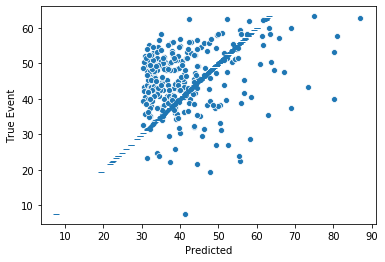

====> Valid NLL loss: 42338.0001 	Improved: *
epoch21
====> Train Loss: 40003.0587 	 NLL: 40002.4144 	 contrastive loss: 0.6443
====> Valid NLL loss: 35756.5713 	Improved: *
epoch22
====> Train Loss: 34202.7668 	 NLL: 34202.1356 	 contrastive loss: 0.6312
====> Valid NLL loss: 30925.7458 	Improved: *
epoch23
====> Train Loss: 29414.3942 	 NLL: 29413.7891 	 contrastive loss: 0.6052
====> Valid NLL loss: 26442.2598 	Improved: *
epoch24
====> Train Loss: 25343.0441 	 NLL: 25342.4597 	 contrastive loss: 0.5843
====> Valid NLL loss: 22554.2147 	Improved: *
epoch25
====> Train Loss: 21688.4007 	 NLL: 21687.8271 	 contrastive loss: 0.5736
====> Valid NLL loss: 19419.3841 	Improved: *
epoch26
====> Train Loss: 18724.4195 	 NLL: 18723.8701 	 contrastive loss: 0.5494
====> Valid NLL loss: 16684.5260 	Improved: *
epoch27
====> Train Loss: 16354.2513 	 NLL: 16353.7213 	 contrastive loss: 0.5300
====> Valid NLL loss: 14846.8080 	Improved: *
epoch28
====> Train Loss: 14719.5111 	 NLL: 14718.9951 	 c

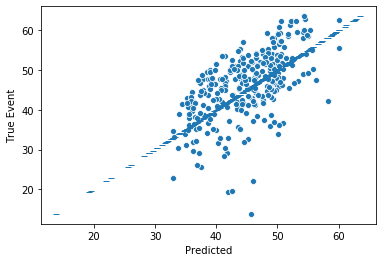

====> Valid NLL loss: 13177.1507 	Improved: *
epoch31
====> Train Loss: 13505.7222 	 NLL: 13505.2616 	 contrastive loss: 0.4606
====> Valid NLL loss: 13094.6500 	Improved: *
epoch32
====> Train Loss: 13543.8405 	 NLL: 13543.3762 	 contrastive loss: 0.4643
====> Valid NLL loss: 13019.2507 	Improved: *
epoch33
====> Train Loss: 13423.6661 	 NLL: 13423.2327 	 contrastive loss: 0.4335
====> Valid NLL loss: 12920.3799 	Improved: *
epoch34
====> Train Loss: 13384.7042 	 NLL: 13384.2586 	 contrastive loss: 0.4455
====> Valid NLL loss: 12925.0167 	Improved:  
epoch35
====> Train Loss: 13342.0673 	 NLL: 13341.6349 	 contrastive loss: 0.4324
====> Valid NLL loss: 12906.3424 	Improved: *
epoch36
====> Train Loss: 13323.9790 	 NLL: 13323.5160 	 contrastive loss: 0.4630
====> Valid NLL loss: 12832.8989 	Improved: *
epoch37
====> Train Loss: 13274.1347 	 NLL: 13273.6813 	 contrastive loss: 0.4534
====> Valid NLL loss: 12865.5729 	Improved:  
epoch38
====> Train Loss: 13272.0883 	 NLL: 13271.6599 	 c

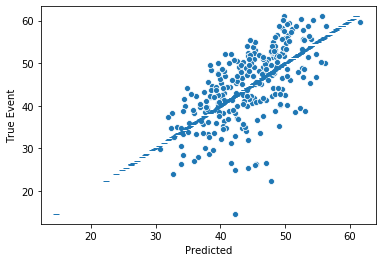

====> Valid NLL loss: 12859.1196 	Improved:  
epoch41
====> Train Loss: 13220.9757 	 NLL: 13220.5458 	 contrastive loss: 0.4299
====> Valid NLL loss: 12951.9346 	Improved:  
epoch42
====> Train Loss: 13225.6749 	 NLL: 13225.2266 	 contrastive loss: 0.4483
====> Valid NLL loss: 12818.2862 	Improved: *
epoch43
====> Train Loss: 13279.9613 	 NLL: 13279.5194 	 contrastive loss: 0.4420
====> Valid NLL loss: 12762.1877 	Improved: *
epoch44
====> Train Loss: 13176.2616 	 NLL: 13175.8109 	 contrastive loss: 0.4507
====> Valid NLL loss: 12773.9132 	Improved:  
epoch45
====> Train Loss: 13170.0187 	 NLL: 13169.5752 	 contrastive loss: 0.4436
====> Valid NLL loss: 12824.4867 	Improved:  
epoch46
====> Train Loss: 13168.9664 	 NLL: 13168.5430 	 contrastive loss: 0.4234
====> Valid NLL loss: 12765.5885 	Improved:  
epoch47
====> Train Loss: 13148.9148 	 NLL: 13148.4844 	 contrastive loss: 0.4304
====> Valid NLL loss: 12794.9337 	Improved:  
epoch48
====> Train Loss: 13143.3875 	 NLL: 13142.9708 	 c

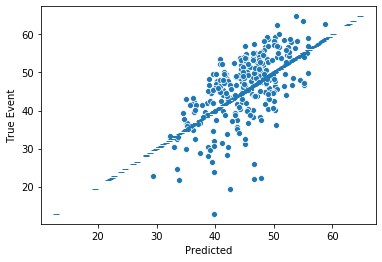

====> Valid NLL loss: 12835.9686 	Improved:  
epoch51
====> Train Loss: 13138.1506 	 NLL: 13137.7252 	 contrastive loss: 0.4254
====> Valid NLL loss: 12725.9454 	Improved: *
epoch52
====> Train Loss: 13111.8537 	 NLL: 13111.4002 	 contrastive loss: 0.4535
====> Valid NLL loss: 12722.2071 	Improved: *
epoch53
====> Train Loss: 13111.7381 	 NLL: 13111.2930 	 contrastive loss: 0.4451
====> Valid NLL loss: 12729.1283 	Improved:  
epoch54
====> Train Loss: 13132.6492 	 NLL: 13132.2242 	 contrastive loss: 0.4250
====> Valid NLL loss: 12771.4539 	Improved:  
epoch55
====> Train Loss: 13107.8243 	 NLL: 13107.3813 	 contrastive loss: 0.4430
====> Valid NLL loss: 12721.1712 	Improved: *
epoch56
====> Train Loss: 13135.3618 	 NLL: 13134.9311 	 contrastive loss: 0.4307
====> Valid NLL loss: 12738.0711 	Improved:  
epoch57
====> Train Loss: 13138.6031 	 NLL: 13138.1878 	 contrastive loss: 0.4153
====> Valid NLL loss: 12754.5380 	Improved:  
epoch58
====> Train Loss: 13107.0987 	 NLL: 13106.6747 	 c

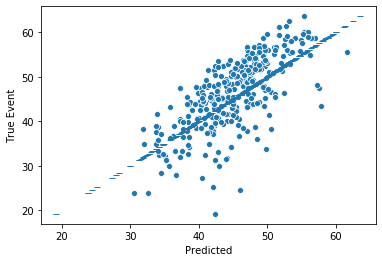

====> Valid NLL loss: 12722.0240 	Improved:  
epoch61
====> Train Loss: 13150.5374 	 NLL: 13150.1199 	 contrastive loss: 0.4175
====> Valid NLL loss: 12868.2655 	Improved:  
epoch62
====> Train Loss: 13128.3587 	 NLL: 13127.9362 	 contrastive loss: 0.4225
====> Valid NLL loss: 12835.4688 	Improved:  
epoch63
====> Train Loss: 13156.6407 	 NLL: 13156.1849 	 contrastive loss: 0.4558
====> Valid NLL loss: 12775.3208 	Improved:  
epoch64
====> Train Loss: 13116.1991 	 NLL: 13115.7611 	 contrastive loss: 0.4380
====> Valid NLL loss: 12756.9529 	Improved:  
epoch65
====> Train Loss: 13071.6303 	 NLL: 13071.1878 	 contrastive loss: 0.4425
====> Valid NLL loss: 12811.6858 	Improved:  
epoch66
====> Train Loss: 13142.0779 	 NLL: 13141.6618 	 contrastive loss: 0.4161
====> Valid NLL loss: 12745.9660 	Improved:  
epoch67
====> Train Loss: 13093.7162 	 NLL: 13093.2862 	 contrastive loss: 0.4299
====> Valid NLL loss: 12748.4260 	Improved:  
epoch68
====> Train Loss: 13091.8983 	 NLL: 13091.4484 	 c

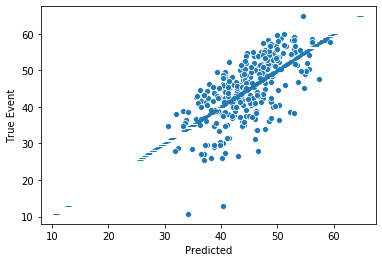

====> Valid NLL loss: 12731.0398 	Improved:  
epoch71
====> Train Loss: 13077.5687 	 NLL: 13077.1287 	 contrastive loss: 0.4400
====> Valid NLL loss: 12737.7116 	Improved:  
epoch72
====> Train Loss: 13076.2160 	 NLL: 13075.7758 	 contrastive loss: 0.4402
====> Valid NLL loss: 12770.8685 	Improved:  
epoch73
====> Train Loss: 13073.7884 	 NLL: 13073.3466 	 contrastive loss: 0.4418
====> Valid NLL loss: 12727.8262 	Improved:  
epoch74
====> Train Loss: 13077.3815 	 NLL: 13076.9625 	 contrastive loss: 0.4190
====> Valid NLL loss: 12765.2236 	Improved:  
epoch75
====> Train Loss: 13087.9939 	 NLL: 13087.5644 	 contrastive loss: 0.4295
====> Valid NLL loss: 12810.7804 	Improved:  
epoch76
====> Train Loss: 13104.9230 	 NLL: 13104.4807 	 contrastive loss: 0.4422
====> Valid NLL loss: 12771.3601 	Improved:  
epoch77
====> Train Loss: 13127.6548 	 NLL: 13127.2184 	 contrastive loss: 0.4364
====> Valid NLL loss: 12727.9086 	Improved:  
epoch78
====> Train Loss: 13111.4183 	 NLL: 13110.9807 	 c

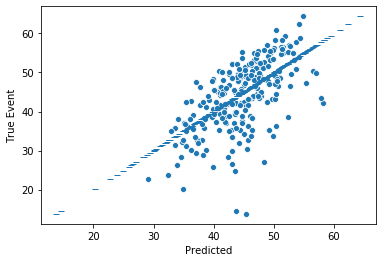

====> Valid NLL loss: 12724.3933 	Improved:  
epoch81
====> Train Loss: 13061.8460 	 NLL: 13061.3974 	 contrastive loss: 0.4486
====> Valid NLL loss: 12731.6868 	Improved:  
epoch82
====> Train Loss: 13056.2522 	 NLL: 13055.8364 	 contrastive loss: 0.4159
====> Valid NLL loss: 12730.0449 	Improved:  
epoch83
====> Train Loss: 13086.2539 	 NLL: 13085.8219 	 contrastive loss: 0.4320
====> Valid NLL loss: 12722.6596 	Improved:  
epoch84
====> Train Loss: 13057.1914 	 NLL: 13056.7831 	 contrastive loss: 0.4083
====> Valid NLL loss: 12759.3006 	Improved:  
epoch85
====> Train Loss: 13045.6148 	 NLL: 13045.1647 	 contrastive loss: 0.4502
====> Valid NLL loss: 12743.8962 	Improved:  
epoch86
====> Train Loss: 13049.2473 	 NLL: 13048.8090 	 contrastive loss: 0.4383
====> Valid NLL loss: 12722.0114 	Improved:  
epoch87
====> Train Loss: 13060.7456 	 NLL: 13060.3080 	 contrastive loss: 0.4376
====> Valid NLL loss: 12770.5181 	Improved:  
epoch88
====> Train Loss: 13063.7471 	 NLL: 13063.3050 	 c

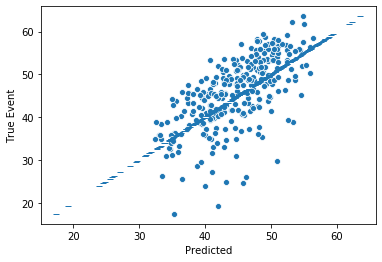

====> Valid NLL loss: 12769.4634 	Improved:  
epoch91
====> Train Loss: 13047.0298 	 NLL: 13046.5940 	 contrastive loss: 0.4358
====> Valid NLL loss: 12713.6341 	Improved: *
epoch92
====> Train Loss: 13052.9826 	 NLL: 13052.5488 	 contrastive loss: 0.4339
====> Valid NLL loss: 12711.4939 	Improved: *
epoch93
====> Train Loss: 13053.4693 	 NLL: 13053.0642 	 contrastive loss: 0.4051
====> Valid NLL loss: 12713.3494 	Improved:  
epoch94
====> Train Loss: 13044.3930 	 NLL: 13043.9609 	 contrastive loss: 0.4321
====> Valid NLL loss: 12812.6387 	Improved:  
epoch95
====> Train Loss: 13067.8431 	 NLL: 13067.4030 	 contrastive loss: 0.4401
====> Valid NLL loss: 12730.2543 	Improved:  
epoch96
====> Train Loss: 13060.8590 	 NLL: 13060.4204 	 contrastive loss: 0.4385
====> Valid NLL loss: 12716.9933 	Improved:  
epoch97
====> Train Loss: 13056.2686 	 NLL: 13055.8173 	 contrastive loss: 0.4512
====> Valid NLL loss: 12733.1271 	Improved:  
epoch98
====> Train Loss: 13063.3422 	 NLL: 13062.9008 	 c

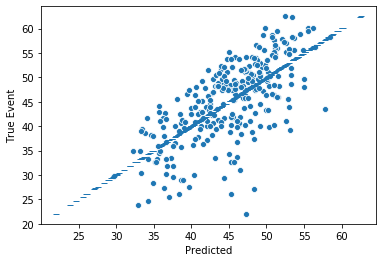

====> Valid NLL loss: 12733.7970 	Improved:  
epoch101
====> Train Loss: 13052.4548 	 NLL: 13052.0503 	 contrastive loss: 0.4045
====> Valid NLL loss: 12714.1316 	Improved:  
epoch102
====> Train Loss: 13061.8613 	 NLL: 13061.4265 	 contrastive loss: 0.4348
====> Valid NLL loss: 12719.1677 	Improved:  
epoch103
====> Train Loss: 13039.1456 	 NLL: 13038.7035 	 contrastive loss: 0.4420
====> Valid NLL loss: 12781.1753 	Improved:  
epoch104
====> Train Loss: 13048.1370 	 NLL: 13047.6974 	 contrastive loss: 0.4397
====> Valid NLL loss: 12748.8731 	Improved:  
epoch105
====> Train Loss: 13049.8632 	 NLL: 13049.4425 	 contrastive loss: 0.4207
====> Valid NLL loss: 12746.8474 	Improved:  
epoch106
====> Train Loss: 13049.5661 	 NLL: 13049.1342 	 contrastive loss: 0.4319
====> Valid NLL loss: 12719.6019 	Improved:  
epoch107
====> Train Loss: 13087.0904 	 NLL: 13086.6635 	 contrastive loss: 0.4269
====> Valid NLL loss: 12740.0475 	Improved:  
epoch108
====> Train Loss: 13051.0923 	 NLL: 13050.

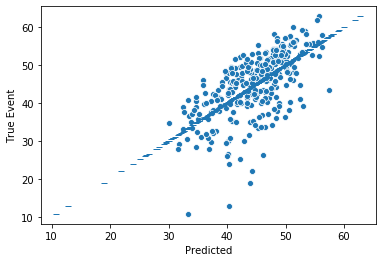

====> Valid NLL loss: 12729.3689 	Improved:  
epoch111
====> Train Loss: 13035.5777 	 NLL: 13035.1185 	 contrastive loss: 0.4592
====> Valid NLL loss: 12740.4515 	Improved:  
epoch112
====> Train Loss: 13060.3620 	 NLL: 13059.9474 	 contrastive loss: 0.4146
====> Valid NLL loss: 12729.8343 	Improved:  
epoch113
====> Train Loss: 13088.5834 	 NLL: 13088.1448 	 contrastive loss: 0.4386
====> Valid NLL loss: 13125.3151 	Improved:  
epoch114
====> Train Loss: 13135.6957 	 NLL: 13135.2858 	 contrastive loss: 0.4099
====> Valid NLL loss: 12805.1062 	Improved:  
epoch115
====> Train Loss: 13060.0642 	 NLL: 13059.6227 	 contrastive loss: 0.4415
====> Valid NLL loss: 12755.2794 	Improved:  
epoch116
====> Train Loss: 13051.0426 	 NLL: 13050.5870 	 contrastive loss: 0.4556
====> Valid NLL loss: 12731.2745 	Improved:  
epoch117
====> Train Loss: 13027.8330 	 NLL: 13027.3883 	 contrastive loss: 0.4447
====> Valid NLL loss: 12757.4770 	Improved:  
epoch118
====> Train Loss: 13051.4616 	 NLL: 13051.

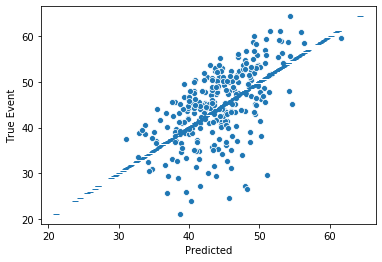

====> Valid NLL loss: 12738.1924 	Improved:  
epoch121
====> Train Loss: 13024.7337 	 NLL: 13024.2969 	 contrastive loss: 0.4368
====> Valid NLL loss: 12762.4697 	Improved:  
epoch122
====> Train Loss: 13036.5841 	 NLL: 13036.1480 	 contrastive loss: 0.4360
====> Valid NLL loss: 12733.9582 	Improved:  
epoch123
====> Train Loss: 13024.5396 	 NLL: 13024.1286 	 contrastive loss: 0.4110
====> Valid NLL loss: 12761.9589 	Improved:  
epoch124
====> Train Loss: 13021.1104 	 NLL: 13020.6761 	 contrastive loss: 0.4343
====> Valid NLL loss: 12748.3884 	Improved:  
epoch125
====> Train Loss: 13022.3729 	 NLL: 13021.9593 	 contrastive loss: 0.4136
====> Valid NLL loss: 12756.8110 	Improved:  
epoch126
====> Train Loss: 13015.0091 	 NLL: 13014.5807 	 contrastive loss: 0.4284
====> Valid NLL loss: 12719.7755 	Improved:  
epoch127
====> Train Loss: 13048.8858 	 NLL: 13048.4436 	 contrastive loss: 0.4422
====> Valid NLL loss: 12731.9616 	Improved:  
epoch128
====> Train Loss: 13041.4858 	 NLL: 13041.

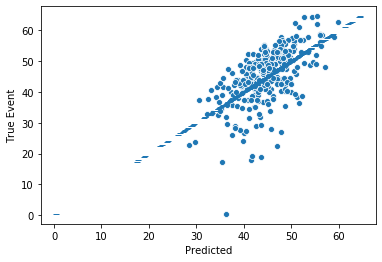

====> Valid NLL loss: 12784.7861 	Improved:  
epoch131
====> Train Loss: 13067.9203 	 NLL: 13067.4851 	 contrastive loss: 0.4352
====> Valid NLL loss: 12814.3798 	Improved:  
epoch132
====> Train Loss: 13030.2880 	 NLL: 13029.8742 	 contrastive loss: 0.4138
====> Valid NLL loss: 12788.0919 	Improved:  
epoch133
====> Train Loss: 13038.3311 	 NLL: 13037.8872 	 contrastive loss: 0.4439
====> Valid NLL loss: 12793.5724 	Improved:  
epoch134
====> Train Loss: 13038.9755 	 NLL: 13038.5322 	 contrastive loss: 0.4433
====> Valid NLL loss: 12725.0740 	Improved:  
epoch135
====> Train Loss: 13028.4768 	 NLL: 13028.0335 	 contrastive loss: 0.4433
====> Valid NLL loss: 12747.7600 	Improved:  
epoch136
====> Train Loss: 13008.5013 	 NLL: 13008.0740 	 contrastive loss: 0.4273
====> Valid NLL loss: 12725.5353 	Improved:  
epoch137
====> Train Loss: 13032.9575 	 NLL: 13032.5341 	 contrastive loss: 0.4235
====> Valid NLL loss: 12781.3488 	Improved:  
epoch138
====> Train Loss: 13040.7918 	 NLL: 13040.

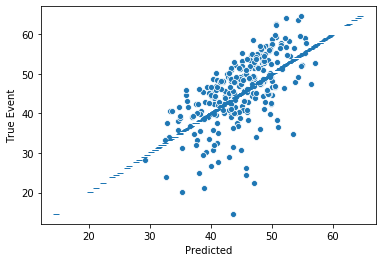

====> Valid NLL loss: 12747.5087 	Improved:  
epoch141
====> Train Loss: 13036.5761 	 NLL: 13036.1351 	 contrastive loss: 0.4410
====> Valid NLL loss: 12747.5475 	Improved:  
epoch142
====> Train Loss: 13012.4228 	 NLL: 13012.0163 	 contrastive loss: 0.4066
====> Valid NLL loss: 12706.6968 	Improved: *
epoch143
====> Train Loss: 13020.8392 	 NLL: 13020.4082 	 contrastive loss: 0.4310
====> Valid NLL loss: 12737.4249 	Improved:  
epoch144
====> Train Loss: 13008.8322 	 NLL: 13008.4056 	 contrastive loss: 0.4266
====> Valid NLL loss: 12711.0038 	Improved:  
epoch145
====> Train Loss: 13015.3056 	 NLL: 13014.8569 	 contrastive loss: 0.4486
====> Valid NLL loss: 12715.6097 	Improved:  
epoch146
====> Train Loss: 13018.3110 	 NLL: 13017.8974 	 contrastive loss: 0.4136
====> Valid NLL loss: 12727.4561 	Improved:  
epoch147
====> Train Loss: 13030.0922 	 NLL: 13029.6383 	 contrastive loss: 0.4539
====> Valid NLL loss: 12740.4881 	Improved:  
epoch148
====> Train Loss: 13026.2466 	 NLL: 13025.

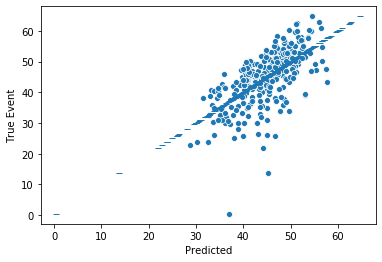

====> Valid NLL loss: 12739.2495 	Improved:  
epoch151
====> Train Loss: 13009.1714 	 NLL: 13008.7278 	 contrastive loss: 0.4436
====> Valid NLL loss: 12745.6999 	Improved:  
epoch152
====> Train Loss: 13060.1642 	 NLL: 13059.7434 	 contrastive loss: 0.4208
====> Valid NLL loss: 12724.9632 	Improved:  
epoch153
====> Train Loss: 13043.2361 	 NLL: 13042.8127 	 contrastive loss: 0.4234
====> Valid NLL loss: 12878.1238 	Improved:  
epoch154
====> Train Loss: 13038.3472 	 NLL: 13037.8841 	 contrastive loss: 0.4631
====> Valid NLL loss: 12736.6392 	Improved:  
epoch155
====> Train Loss: 13017.7028 	 NLL: 13017.2534 	 contrastive loss: 0.4494
====> Valid NLL loss: 12838.8231 	Improved:  
epoch156
====> Train Loss: 13043.3878 	 NLL: 13042.9857 	 contrastive loss: 0.4022
====> Valid NLL loss: 12762.7838 	Improved:  
epoch157
====> Train Loss: 13026.9848 	 NLL: 13026.5405 	 contrastive loss: 0.4443
====> Valid NLL loss: 12785.0023 	Improved:  
epoch158
====> Train Loss: 12988.4405 	 NLL: 12988.

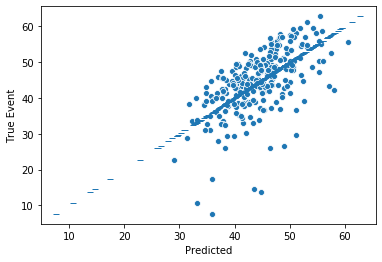

====> Valid NLL loss: 12765.7623 	Improved:  
epoch161
====> Train Loss: 13013.8832 	 NLL: 13013.4626 	 contrastive loss: 0.4206
====> Valid NLL loss: 12757.2912 	Improved:  
epoch162
====> Train Loss: 13026.2607 	 NLL: 13025.8136 	 contrastive loss: 0.4471
====> Valid NLL loss: 12738.8841 	Improved:  
epoch163
====> Train Loss: 13058.5776 	 NLL: 13058.1477 	 contrastive loss: 0.4299
====> Valid NLL loss: 12731.0131 	Improved:  
epoch164
====> Train Loss: 13007.3353 	 NLL: 13006.8815 	 contrastive loss: 0.4538
====> Valid NLL loss: 12741.7628 	Improved:  
epoch165
====> Train Loss: 13021.3738 	 NLL: 13020.9298 	 contrastive loss: 0.4441
====> Valid NLL loss: 12733.1938 	Improved:  
epoch166
====> Train Loss: 13027.9780 	 NLL: 13027.5494 	 contrastive loss: 0.4286
====> Valid NLL loss: 12720.6022 	Improved:  
epoch167
====> Train Loss: 13004.0276 	 NLL: 13003.5837 	 contrastive loss: 0.4439
====> Valid NLL loss: 12743.5851 	Improved:  
epoch168
====> Train Loss: 13005.4663 	 NLL: 13005.

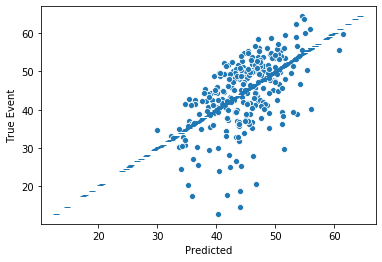

====> Valid NLL loss: 12713.8450 	Improved:  
epoch171
====> Train Loss: 13000.1278 	 NLL: 12999.7087 	 contrastive loss: 0.4192
====> Valid NLL loss: 12710.7473 	Improved:  
epoch172
====> Train Loss: 13013.5941 	 NLL: 13013.1637 	 contrastive loss: 0.4304
====> Valid NLL loss: 12810.1296 	Improved:  
epoch173
====> Train Loss: 13042.4473 	 NLL: 13041.9987 	 contrastive loss: 0.4487
====> Valid NLL loss: 12745.7766 	Improved:  
epoch174
====> Train Loss: 13021.0746 	 NLL: 13020.6147 	 contrastive loss: 0.4599
====> Valid NLL loss: 12714.2188 	Improved:  
epoch175
====> Train Loss: 13013.7596 	 NLL: 13013.3285 	 contrastive loss: 0.4311
====> Valid NLL loss: 12722.9236 	Improved:  
epoch176
====> Train Loss: 12984.9184 	 NLL: 12984.4757 	 contrastive loss: 0.4427
====> Valid NLL loss: 12804.7836 	Improved:  
epoch177
====> Train Loss: 13002.6678 	 NLL: 13002.2197 	 contrastive loss: 0.4481
====> Valid NLL loss: 12744.5712 	Improved:  
epoch178
====> Train Loss: 13009.8444 	 NLL: 13009.

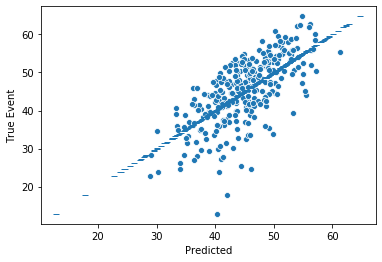

====> Valid NLL loss: 12734.3433 	Improved:  
epoch181
====> Train Loss: 13011.0712 	 NLL: 13010.6276 	 contrastive loss: 0.4436
====> Valid NLL loss: 12745.3336 	Improved:  
epoch182
====> Train Loss: 13037.0578 	 NLL: 13036.6320 	 contrastive loss: 0.4258
====> Valid NLL loss: 12747.2819 	Improved:  
epoch183
====> Train Loss: 12997.5006 	 NLL: 12997.0799 	 contrastive loss: 0.4207
====> Valid NLL loss: 12714.1267 	Improved:  
epoch184
====> Train Loss: 13018.0572 	 NLL: 13017.6178 	 contrastive loss: 0.4393
====> Valid NLL loss: 12744.8746 	Improved:  
epoch185
====> Train Loss: 13009.0862 	 NLL: 13008.6630 	 contrastive loss: 0.4232
====> Valid NLL loss: 12757.7515 	Improved:  
epoch186
====> Train Loss: 12998.8919 	 NLL: 12998.4601 	 contrastive loss: 0.4317
====> Valid NLL loss: 12741.2308 	Improved:  
epoch187
====> Train Loss: 12994.5166 	 NLL: 12994.0951 	 contrastive loss: 0.4215
====> Valid NLL loss: 12772.4112 	Improved:  
epoch188
====> Train Loss: 13004.3899 	 NLL: 13003.

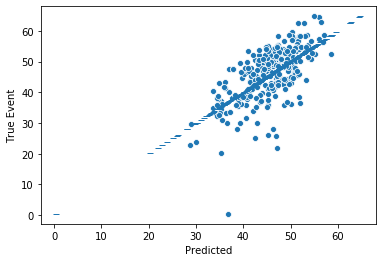

====> Valid NLL loss: 12744.9768 	Improved:  
epoch191
====> Train Loss: 13014.8920 	 NLL: 13014.4679 	 contrastive loss: 0.4241
====> Valid NLL loss: 12722.2676 	Improved:  
epoch192
====> Train Loss: 13007.6557 	 NLL: 13007.2138 	 contrastive loss: 0.4419
====> Valid NLL loss: 12865.7948 	Improved:  
Model stopped due to early stopping


In [179]:
best_valid_loss = np.inf
best_epoch = 0
# encoder.load_state_dict(torch.load(enc_path))
# decoder.load_state_dict(torch.load(dec_path))

train_loss_hist = []
train_rec_hist = []
train_ctr_hist = []

valid_loss_hist = []

ctr_learning = True
for epoch in range(1, epochs + 1):


    train_loss = 0
    rec_loss = 0
    ctr_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "

    
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
#         print(i)
        # training encoder and decoder
        
        x = torch.cat([x1,x2]).to(device).float()
        y = torch.cat([y1,y2])
        e = torch.cat([e1,e2])
                
        if not ctr_learning:
            ctr_wt = 0
            
        clf.train()
        encoder.train()
        decoder.train()
        z = encoder(x)
        # exclude right censored subjects when training decoder
#             p_raw = decoder(z)

#             y_cat = batch_t_categorize(y, e, tt)
#             keep_idx = np.arange(len(e))

#             y_loglikeli = -((p_raw[keep_idx,:]*torch.tensor(y_cat[keep_idx,:])).sum(axis=1)+1e-6).log().mean()

        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss).squeeze()).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
        rec_loss_ = closs + eloss


        # contrastive learning step
        delete_loc = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        keep_idx_1 = torch.where(delete_loc==0)[0]
        keep_idx_2 = keep_idx_1+len(e1)

        batch_label = (1*(y[keep_idx_1] > y[keep_idx_2])).to(device).squeeze().float()

        batch_pair = torch.cat([z[keep_idx_1], z[keep_idx_2]],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        contrastive_loss = BCEloss(pred_label.squeeze(), batch_label.float())

        loss = rec_loss_ + ctr_wt*contrastive_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1e-4)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-4)
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)

        train_loss += loss.item()
        rec_loss += rec_loss_.item()
        ctr_loss += contrastive_loss.item()

        opt_enc.step()  
        opt_dec.step()  
        opt_clf.step()          

        
    train_loss = train_loss/(i+1)
    rec_loss = rec_loss/(i+1) 
    ctr_loss = ctr_loss/(i+1)  

    print('====> Train Loss: {:.4f} \t NLL: {:.4f} \t contrastive loss: {:.4f}'.format(train_loss, rec_loss, ctr_loss))
    
    encoder.eval()
    decoder.eval()
    clf.eval()
    
    valid_loss = 0
    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        
        z = encoder(x)
        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss).squeeze()).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()

        valid_loss_ = eloss.item()

        valid_loss += valid_loss_


    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    train_rec_hist.append(rec_loss)
    train_ctr_hist.append(ctr_loss)
    valid_loss_hist.append(valid_loss)
    
    if epoch % 10 == 0:
        
        sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
        plt.plot(y[e==1], y[e==1])
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
#         plt.xlim(min(y), max(y))
#         plt.ylim(min(y), max(y))
        
#         subj = np.random.choice(len(e))
#         plt.figure()

#         plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

#         sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
#         true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
#         sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
#         plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.
                
#         plt.title(r'$\delta$='+str(e[subj].item()))

        plt.show()

    save_model = 0
    if (best_valid_loss > valid_loss):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss
        torch.save(encoder.state_dict(), enc_path)
        torch.save(decoder.state_dict(), dec_path)
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid NLL loss: {:.4f} \tImproved: {}'.format(valid_loss, improved_str))

#     if ctr_learning and (epoch - best_epoch >=20):
#         ctr_learning = False
#         print('Contrastive learning stopped')
    
#     if not ctr_learning and (epoch - best_epoch >=50):
#         print('Model stopped due to early stopping')
#         break
    if (epoch - best_epoch >=50):
        print('Model stopped due to early stopping')
        break        

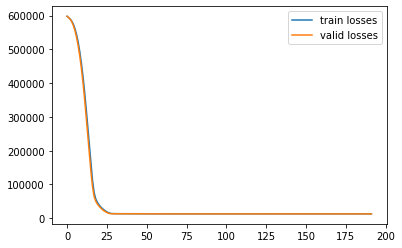

In [180]:
plt.plot(train_rec_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
# stop_ctr = train_ctr_hist.index(0)
# plt.axvline(stop_ctr,linestyle='--',color=emp_color,label='stop \ncontrastive \nlearning')

plt.legend()

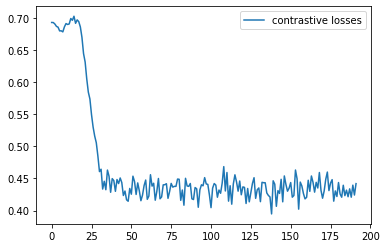

In [181]:
plt.plot(train_ctr_hist,label="contrastive losses")
plt.legend()

In [182]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))
for i, (x, y, e) in enumerate(pair1):
    break
enc_path, dec_path

('/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/enc_1.pt',
 '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/dec_1.pt')

Text(0, 0.5, 'True Event')

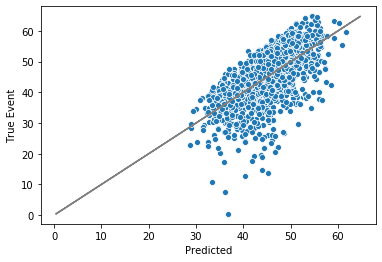

In [183]:
encoder.eval()
decoder.eval()
x = (torch.tensor(test['x']).to(device).float()-mean)/std
y = test['t']
e = test['e']
z = encoder(x.to(device).float())
t_hat = decoder(z)
sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
plt.plot(y[e==1], y[e==1], color='gray')
plt.xlabel('Predicted')
plt.ylabel('True Event')
# plt.xlim(min(t_hat.squeeze().detach()), max(y))
# plt.ylim(min(t_hat.squeeze().detach()), max(y))

Text(0, 0.5, 'True Event')

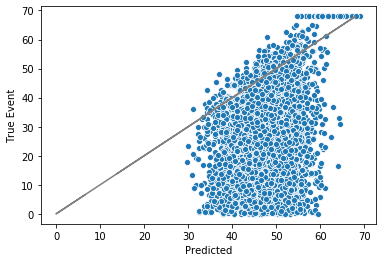

In [186]:
sns.scatterplot(t_hat[e==0].detach().numpy().squeeze(), y[e==0])
plt.plot(y[e==0], y[e==0], color='gray')
plt.xlabel('Predicted')
plt.ylabel('True Event')


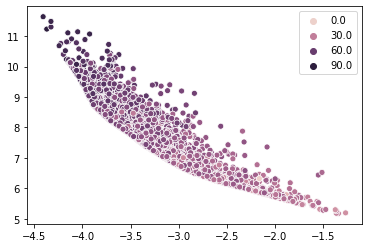

In [185]:
sns.scatterplot(z[:,0].detach(), z[:,1].detach(), hue=test['T'])

In [820]:
# torch.where(e==1),
np.where(test['t']>t_max)

(array([  17,   19,  105,  198,  348,  472,  743,  749,  940, 1009, 1085,
        1180, 1209, 1438, 1504, 1565, 1825, 1951, 2096, 2120, 2251, 2499,
        2555, 2775, 3088, 3090, 3246, 3305, 3338, 3923, 4054, 4202, 4252,
        4298, 4317, 4318, 4357, 4373, 4511, 4626, 4678, 4772, 4970]),)

(tensor(68.), tensor(0))

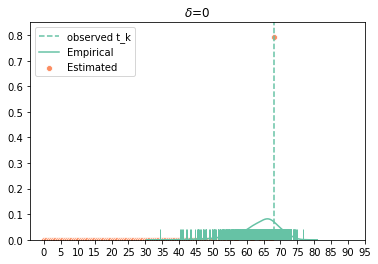

In [825]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

y = torch.tensor(test['t']).to(device).float()
e = torch.tensor(test['e']).to(device)
y_cat = batch_t_categorize(y, e, tt)


subj = 4511


plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

plt.legend(loc='best')
plt.title(r'$\delta$='+str(e[subj].item()))
y[subj], e[subj]

# y_cat = batch_t_categorize(y, e, tt)

# subj = 331
# x = x.to(device).float()
# z = encoder(x)
# p_raw = decoder(z)
# plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

# sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
# true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
# sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
# plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

# plt.legend(loc='upper right')
# plt.title(r'$\delta$='+str(e[subj].item()))
# y[subj], e[subj]

In [431]:
e.float().mean()

tensor(0.2660)

In [46]:
np.arange(0, 70, step=5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In [240]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "
    clf.train()
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):

        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        loss = BCEloss(pred_label.squeeze(), batch_label.float())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)
        train_loss += loss.item()
        opt_clf.step()    

    train_loss = train_loss/(i+1)
    
    clf.eval()
    valid_loss = 0
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(v_pair1, v_pair2)):
        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        valid_loss_ = BCEloss(pred_label.squeeze(), batch_label.float())

        valid_loss += valid_loss_



    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    
    save_model = 0
    if (best_valid_loss > valid_loss_):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss_
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid Pair number: {} \tCE loss: {:.4f} \tImproved: {}'.format(len(e1), valid_loss_.item(), improved_str))

    if epoch - best_epoch >=50:
        print('Model stopped due to early stopping')
        break

epoch1
====> Valid Pair number: 649 	CE loss: 0.8527 	Improved: *
epoch2
====> Valid Pair number: 641 	CE loss: 0.7976 	Improved: *
epoch3
====> Valid Pair number: 653 	CE loss: 0.7649 	Improved: *
epoch4
====> Valid Pair number: 657 	CE loss: 0.6971 	Improved: *
epoch5
====> Valid Pair number: 630 	CE loss: 0.6617 	Improved: *
epoch6
====> Valid Pair number: 632 	CE loss: 0.6347 	Improved: *
epoch7
====> Valid Pair number: 648 	CE loss: 0.6240 	Improved: *
epoch8
====> Valid Pair number: 643 	CE loss: 0.6128 	Improved: *
epoch9
====> Valid Pair number: 658 	CE loss: 0.6176 	Improved:  
epoch10
====> Valid Pair number: 638 	CE loss: 0.5913 	Improved: *
epoch11
====> Valid Pair number: 656 	CE loss: 0.5862 	Improved: *
epoch12
====> Valid Pair number: 621 	CE loss: 0.5889 	Improved:  
epoch13
====> Valid Pair number: 667 	CE loss: 0.5741 	Improved: *
epoch14
====> Valid Pair number: 605 	CE loss: 0.5729 	Improved: *
epoch15
====> Valid Pair number: 643 	CE loss: 0.5616 	Improved: *
epoc

====> Valid Pair number: 664 	CE loss: 0.4939 	Improved:  
epoch124
====> Valid Pair number: 674 	CE loss: 0.4727 	Improved:  
epoch125
====> Valid Pair number: 637 	CE loss: 0.5000 	Improved:  
epoch126
====> Valid Pair number: 648 	CE loss: 0.5156 	Improved:  
epoch127
====> Valid Pair number: 648 	CE loss: 0.4763 	Improved:  
epoch128
====> Valid Pair number: 664 	CE loss: 0.4897 	Improved:  
epoch129
====> Valid Pair number: 626 	CE loss: 0.4832 	Improved:  
epoch130
====> Valid Pair number: 617 	CE loss: 0.4953 	Improved:  
epoch131
====> Valid Pair number: 668 	CE loss: 0.4815 	Improved:  
epoch132
====> Valid Pair number: 661 	CE loss: 0.4700 	Improved:  
epoch133
====> Valid Pair number: 653 	CE loss: 0.5065 	Improved:  
epoch134
====> Valid Pair number: 682 	CE loss: 0.4861 	Improved:  
epoch135
====> Valid Pair number: 640 	CE loss: 0.4857 	Improved:  
epoch136
====> Valid Pair number: 647 	CE loss: 0.4832 	Improved:  
epoch137
====> Valid Pair number: 618 	CE loss: 0.5129 	I

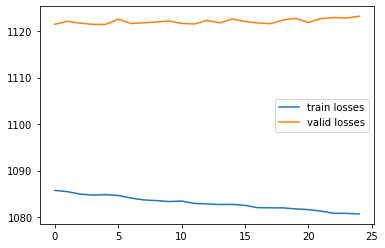

In [396]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [242]:
import pandas as pd


plot_df = pd.DataFrame({'true': batch_label.detach().numpy(), 'pred': pred_label.squeeze().detach().numpy(),\
                        'dataPair1':batch_pair[:,0].detach().numpy(), 'dataPair2':batch_pair[:,1].detach().numpy()})
plot_df.head()

,true,pred,dataPair1,dataPair2
0,1.0,0.744528,25.781141,43.624172
1,1.0,0.744528,15.027925,21.310776
2,1.0,0.744528,20.414146,30.561441
3,1.0,0.744528,22.647816,30.683744
4,0.0,0.742164,15.022316,19.621126


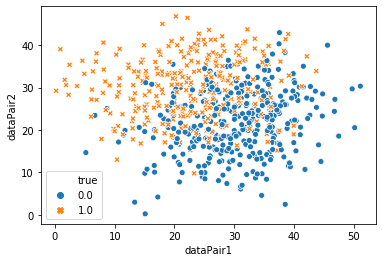

In [243]:
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")


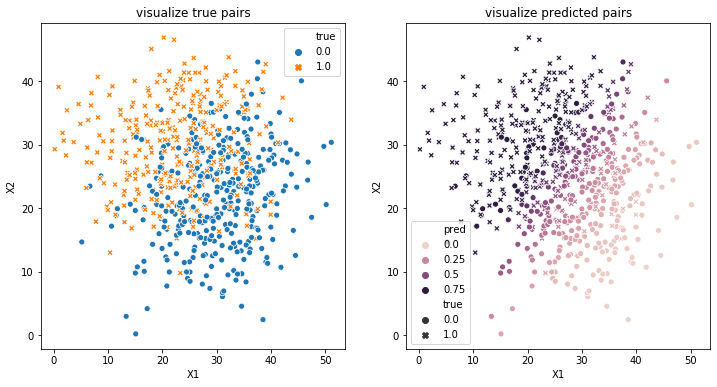

In [244]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)

_ = plt.title('visualize true pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')
plt.subplot(1, 2, 2)



_ = plt.title('visualize predicted pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="pred", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

In [257]:
subj = np.random.sample(np.where(test['e']==1))
subj

TypeError: only integer scalar arrays can be converted to a scalar index

In [258]:
np.where(test['e']==1)

(array([  14,   16,   19, ..., 4992, 4996, 4998]),)

In [288]:
np.where(test['e']==1)
subj = 14

In [422]:
# Restore variables from disk.
clf.load_state_dict(torch.load(clf_path))
print("Model restored.")

# new object to predict g(x_subj)
# on the left
# subj = 2
# on the right
# subj=6
# relatively good 
# subj=8
x_subj = test['x'][subj]     # You can play with this
# x_subj = train['x'][subj]
draw_dataset = test
# Return evenly spaced numbers over a specified interval.
# is tt the we want?
# change tt to percentage scale

tt = np.percentile(train['T'],np.delete(np.linspace(0.,100.,1000, endpoint=False),0))
tt_bin = np.ones(len(tt))
# tt = np.linspace(ST[0]-0.5,ST[-1]+0.5,1000).reshape(1000)
# tt_bin = [y-x for x, y in zip(tt[:-1], tt[1:])]
# tt = np.delete(tt,0)

# SFX sorted original training dataset
x_subj_query = np.concatenate((np.tile(x_subj,[SX.shape[0],1]),SX),axis=1)

prob_subj = clf(torch.tensor(x_subj_query).to(device).float()).squeeze().detach().numpy()

# ST: sorted g(X_train)
# returns a matrix of size(tt)*size(ST)
# each ST corresponding to SFX
TC = compute_concord(tt,ST)

EPS = 1e-10
#aggregate information over bins
# binomial log-likelihood
tau = 0.2
score = np.mean(np.log(prob_subj+EPS)*TC+np.log(1-prob_subj+EPS)*(1-TC),axis=1)
score = score/tau
# normalize based on bin size!
post_prob = (np.exp(score)*tt_bin)/np.sum(np.exp(score)*tt_bin)

# np.save(output_dir+'/'+'M'+str(M0)+'replicate'+str(replicate_number)+"_MLP_post_prob",post_prob)




RuntimeError: Error(s) in loading state_dict for SimpleMLP:
	size mismatch for net.0.weight: copying a param with shape torch.Size([32, 2]) from checkpoint, the shape in current model is torch.Size([32, 4]).

In [2]:
width = 18
height = 6
plt.figure(figsize=(width, height))
plt.subplot(1,2,1)

plt.plot(SX, prob_subj, 'o')
plt.xlabel("sorted training X")
plt.ylabel("classifier output")
plt.axvline(draw_dataset['x'][subj],linestyle='--', label='x_k')
plt.legend()

plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")


# plt.subplot(1,3,2)
# plt.plot(ST, prob_subj, 'o')
# plt.xlabel("training T based on sorted X")
# plt.ylabel("classifier output")
# plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
# plt.legend()
# plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")
# # plt.xlim(50,80)

plt.subplot(1,2,2)
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']

plt.plot(tt, post_prob/0.1, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False,label="Empirical")
plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')


#
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')


plt.legend()
plt.title("Time-to-event distribution, event label:{}".format(test['e'][subj]))

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'Time-to-event distribution')

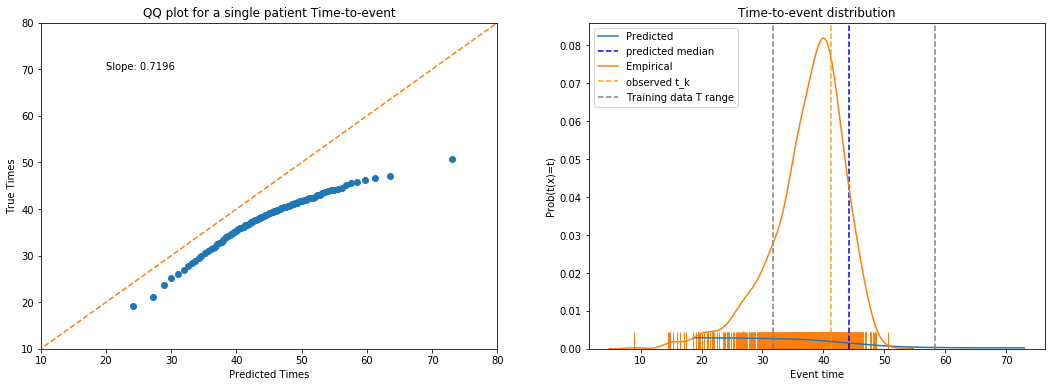

In [282]:
# calculate QQ-plot
import numpy as np
import matplotlib.pyplot as plt


pred_quantiles = calculate_quantiles(post_prob, tt, percentiles=np.linspace(0,1,100))
true_quantiles = np.percentile(true_T,np.linspace(0,100,100))
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(pred_quantiles, true_quantiles)

width = 18
height = 6
plt.figure(figsize=(width, height))

plt.subplot(1,2,1)
plt.text(20,70, 'Slope: '+str(np.round(slope,4)))
plt.plot(pred_quantiles, true_quantiles, 'o')
plt.plot(np.linspace(0,100,100),np.linspace(0,100,100), linestyle='--')
plt.xlim(10,80)
plt.ylim(10,80)
plt.xlabel('Predicted Times')
plt.ylabel('True Times')
plt.title('QQ plot for a single patient Time-to-event')

plt.subplot(1,2,2)
plt.plot(tt, post_prob, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False, label="Empirical")

plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')

plt.legend()
plt.title("Time-to-event distribution")

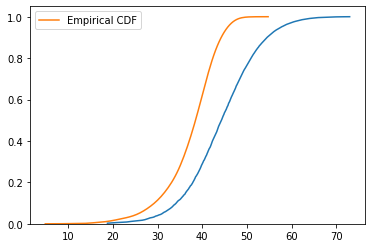

In [283]:
plt.plot(tt,np.cumsum(post_prob))
sns.distplot(true_T, hist=False, label="Empirical CDF", kde_kws=dict(cumulative=True))
